# Business Problem

##### *The data used on this project is from the Kaggle Competition: [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales/overview) and the Business Problem is an adaptation from the challenge given by the competition*

- What is the context of the problem?
 - On a monthly meeting to talk about results between the CFO and the Store Managers, the CFO asked for each Store to have a prediction of sales for the next 6 weeks.
 

- What is the root cause of the problem? Why doing a sales prediction?
 - In a talk with the CFO, he explained he is planning to do some renovations on the stores and wants to know the future sales so he can better plan the expenses by store and even advance some part of the money.


- Who is the owner of the problem? Who is the one more interested?
 - The CFO.


- What is the format of the solution?
 - Sales, in $, for the next 6 weeks for each store.
 - The problem is a prediction, we will be using regression techniques.
 - The solution needs to be accessible by phone, so we will develop a Telegram Bot to deliver the results.

# 0. Imports

In [1]:
import math
import inflection
import random
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from scipy import stats
from tabulate import tabulate
from matplotlib import pyplot as plt
from boruta import BorutaPy

from IPython.display import Image
from IPython.core.display import HTML

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 0.1. Helper Function

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - ((k-1)*(r-1))/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))


def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))


def mean_percentage_error(y, yhat):
    return np.mean((y-yhat)/y)


def errors_calculator(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}, index=[0])


def cross_validation(train_dataset, kfold, model, model_name, verbose=False):
    mae_values = []
    mape_values = []
    rmse_values = []
    
    for i in reversed(range(0, kfold)):
        if verbose:
            print(f'\nKFold Number: {i+1}')
        
        # start and end date of validation set - always 6 weeks periods
        start_date_validation = train_dataset['date'].max() - datetime.timedelta(days=(i+1)*6*7)
        end_date_validation = train_dataset['date'].max() - datetime.timedelta(days=i*6*7)
        
        # split dataset
        training = train_dataset[train_dataset['date'] < start_date_validation]
        validation = train_dataset[(train_dataset['date'] >= start_date_validation) & (train_dataset['date'] <= end_date_validation)]
        
        # prepare training data
        x_train = training.copy()
        y_train = training['sales'].copy()
        
        competition_distance_rs = RobustScaler()
        competition_time_month_rs = RobustScaler()
        promo_time_week_rs = RobustScaler()

        # competition_distance
        x_train['competition_distance'] = competition_distance_rs.fit_transform(x_train[['competition_distance']].values)

        # competition_time_month
        x_train['competition_time_month'] = competition_time_month_rs.fit_transform(x_train[['competition_time_month']].values)

        # promo_time_week
        x_train['promo_time_week'] = promo_time_week_rs.fit_transform(x_train[['promo_time_week']].values)
        
        # store_type - Label Enconding
        le = LabelEncoder()
        x_train['store_type'] = le.fit_transform(x_train['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        x_train['assortment'] = x_train['assortment'].map(assortment_dict)
        
        # day of week
        x_train['day_of_week_sin'] = x_train['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        x_train['day_of_week_cos'] = x_train['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

        # month
        x_train['month_sin'] = x_train['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        x_train['month_cos'] = x_train['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        # day
        x_train['day_sin'] = x_train['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        x_train['day_cos'] = x_train['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        # week of year
        x_train['week_of_year_sin'] = x_train['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        x_train['week_of_year_cos'] = x_train['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
        
        # response variable
        y_train = np.log1p(y_train)
        
        # selected columns
        features_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                             'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                             'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
                             'week_of_year_sin', 'week_of_year_cos']

        x_train = x_train[features_selected]
        
        # prepare validation data
        x_validation = validation.copy()
        y_validation = validation['sales'].copy()
        
        # competition_distance
        x_validation['competition_distance'] = competition_distance_rs.transform(x_validation[['competition_distance']].values)

        # competition_time_month
        x_validation['competition_time_month'] = competition_time_month_rs.transform(x_validation[['competition_time_month']].values)

        # promo_time_week
        x_validation['promo_time_week'] = promo_time_week_rs.transform(x_validation[['promo_time_week']].values)
        
        # store_type - Label Enconding
        x_validation['store_type'] = le.transform(x_validation['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        x_validation['assortment'] = x_validation['assortment'].map(assortment_dict)
        
        # day of week
        x_validation['day_of_week_sin'] = x_validation['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        x_validation['day_of_week_cos'] = x_validation['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

        # month
        x_validation['month_sin'] = x_validation['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        x_validation['month_cos'] = x_validation['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        # day
        x_validation['day_sin'] = x_validation['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        x_validation['day_cos'] = x_validation['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        # week of year
        x_validation['week_of_year_sin'] = x_validation['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        x_validation['week_of_year_cos'] = x_validation['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
        
        # selected columns
        features_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                             'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                             'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
                             'week_of_year_sin', 'week_of_year_cos']

        x_validation = x_validation[features_selected]
        
        # model
        model = model.fit(x_train, y_train)
        
        # prediction
        yhat = model.predict(x_validation)
        
        # performance
        model_results = errors_calculator(model_name, y_validation, np.expm1(yhat))
        
        # store performance of each kfold iteration
        mae_values.append(model_results['MAE'])
        mape_values.append(model_results['MAPE'])
        rmse_values.append(model_results['RMSE'])
        
    return pd.DataFrame({'Model': model_name, 
                         'MAE CV': np.round(np.mean(mae_values), 2).astype(str) + ' +/- ' + np.round(np.std(mae_values), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_values), 2).astype(str) + ' +/- ' + np.round(np.std(mape_values), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_values), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_values), 2).astype(str)
                        }, index=[0])

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/olini/Projects/sales-prediction-ds-em-producao/DataScienceEmProducao/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 1. Loading Data

In [4]:
df_train_raw = pd.read_csv('data/train.csv', low_memory=False)

In [5]:
df_train_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

In [7]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
# merge dataframes
df_raw = pd.merge(df_train_raw, df_store_raw, how='left', on='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 2. Data Description

In [9]:
# create a copy to create a checkpoint
df_dd = df_raw.copy()

## 2.1. Rename Columns

In [10]:
old_cols_name = list(df_dd.columns) 
snake_case_func = lambda x: inflection.underscore(x)
new_cols_name = list(map(snake_case_func, old_cols_name))
df_dd.columns = new_cols_name

## 2.2. Data Dimension

In [11]:
print(f'Number of rows: {df_dd.shape[0]}')
print(f'Number of columns: {df_dd.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 2.3. Data Types

In [12]:
df_dd.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [13]:
df_dd.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [14]:
# change data type for the field date, from object to datetime
df_dd['date'] = pd.to_datetime(df_dd['date'])
df_dd.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [15]:
df_dd.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 2.4. Check NA

In [16]:
df_dd.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 2.4.1. Fill NA

Let's fill all the NAs using some business assumptions.

#### 2.4.1.1. competition_distance

if NA, means that there is no competitor around, or the nearest competitor is too far away. So, lets fill it with a huge number, way beyond the max found on the dataset

In [17]:
# get max
df_dd['competition_distance'].max()

75860.0

In [18]:
df_dd['competition_distance'].fillna(200000, inplace=True)

with apply and math.isnan() = 303ms

#### 2.4.1.2. competition_open_since_month and competition_open_since_year

if NA, fill with the date of the sale, as it is ilogical to have a competitor nearby but no date of its opening

In [19]:
df_dd['competition_open_since_month'].fillna(df_dd['date'].dt.month, inplace=True)
df_dd['competition_open_since_year'].fillna(df_dd['date'].dt.year, inplace=True)

#### 2.4.1.3. promo2_since_week and promo2_since_year

if NA, also fill with the date of sale. This is a first cycle, maybe we change it later

In [20]:
df_dd['promo2_since_week'].fillna(df_dd['date'].dt.isocalendar().week, inplace=True)
df_dd['promo2_since_year'].fillna(df_dd['date'].dt.year, inplace=True)

#### 2.4.1.4. promo_interval

This columns contains a list of months when the Promo2 is started. We will create a new column called is_promo, to indicate if the sale date is on a month from this list. If promo_interval is NA, fill with 0

In [21]:
month_dict = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

df_dd['promo_interval'].fillna(0, inplace=True)

df_dd['date_month'] = df_dd['date'].dt.month.map(month_dict)

df_dd['is_promo'] = df_dd[['promo_interval', 'date_month']].apply(
    lambda x: 
        0 if x['promo_interval'] == 0 else 
        1 if x['date_month'] in x['promo_interval'].split(',') else 0,
    axis=1)

## 2.4.2. Recheck Data Types

Due to the operations we did filling the NAs, we will recheck the data types to see if there is any bad-typed column

In [22]:
df_dd.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
date_month                              object
is_promo                                 int64
dtype: object

In [23]:
# lets change the type of competition_open_since_month, competition_open_since_year, promo2_since_week and promo2_since_year from float64 to int
df_dd['competition_open_since_month'] = df_dd['competition_open_since_month'].astype(int)
df_dd['competition_open_since_year'] = df_dd['competition_open_since_year'].astype(int)
df_dd['promo2_since_week'] = df_dd['promo2_since_week'].astype(int)
df_dd['promo2_since_year'] = df_dd['promo2_since_year'].astype(int)

In [24]:
df_dd.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
date_month                              object
is_promo                                 int64
dtype: object

## 2.5. Descriptive Statistics

In [25]:
# lets first separate the attributes in numerical and categorical
num_attributes = df_dd.select_dtypes(include=['int64', 'float64'])
cat_attributes = df_dd.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 2.5.1. Numerical Attributes

In [26]:
# Central Tendency
ct1 = num_attributes.apply(np.mean)
ct2 = num_attributes.apply(np.median)

# Dispersion
d1 = num_attributes.apply(np.std)
d2 = num_attributes.min()
d3 = num_attributes.max()
d4 = num_attributes.apply(lambda x: x.max() - x.min())
d5 = num_attributes.skew()
d6 = num_attributes.kurtosis()

In [27]:
m = pd.DataFrame([ct1, ct2, d1, d2, d3, d4, d5, d6]).T.reset_index()
m.columns = ['attribute', 'mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']

In [28]:
m

,attribute,mean,median,std,min,max,range,skew,kurtosis
0,store,558.429727,558.0,321.908493,1.0,1115.0,1114.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997390,1.0,7.0,6.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.924283,0.0,41551.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411506,0.0,7388.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485758,0.0,1.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,12547.646829,20.0,200000.0,199980.0,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,3.311085,1.0,12.0,11.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515591,1900.0,2015.0,115.0,-7.235657,124.071304


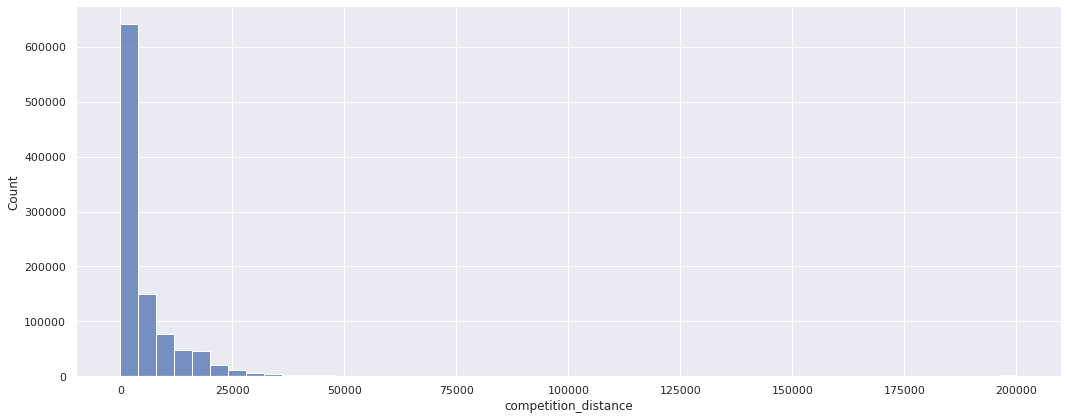

In [29]:
sns.displot(df_dd['competition_distance'], kde=False, height=6, aspect=2.5, bins=50);

### 2.5.2. Categorical Attributes

In [30]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
date_month        12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

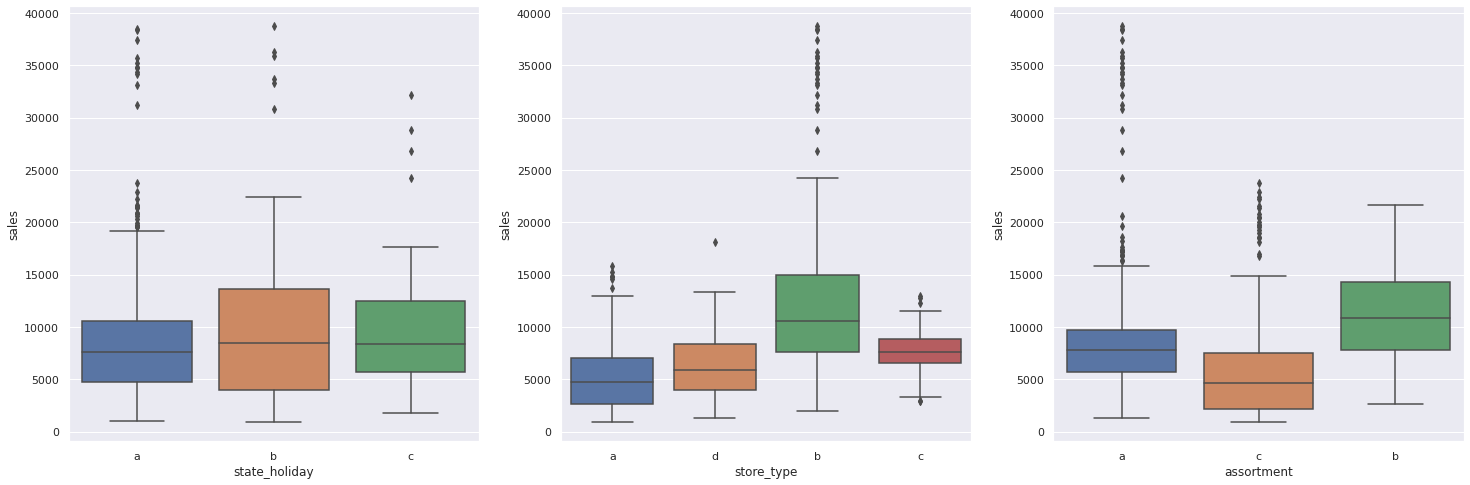

In [31]:
df_dd_aux = df_dd[(df_dd['sales'] > 0) & (df_dd['state_holiday'] != '0')]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=df_dd_aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=df_dd_aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=df_dd_aux)

# 3. Hypotheses and Feature Engineering

## 3.1. Mind Map of Agents and Agents' Attributes

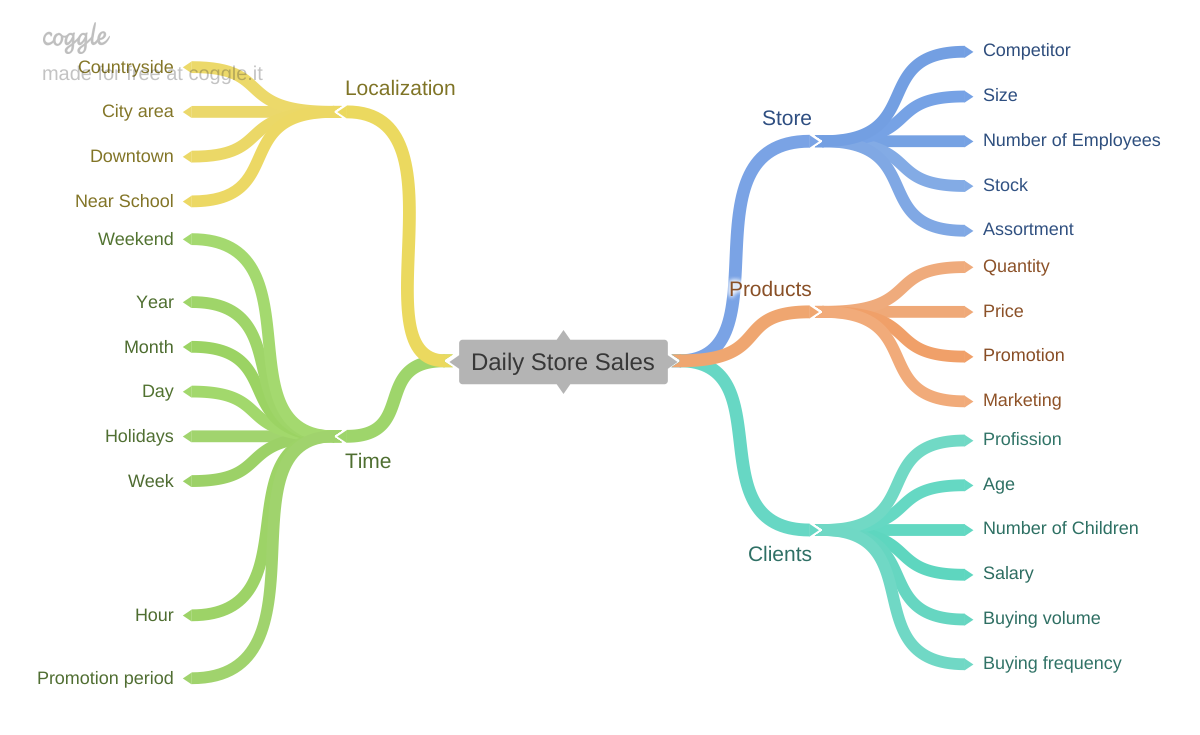

In [32]:
Image('img/mindmap_agents-attributes.png')

## 3.2. Hypotheses Creation

### 3.2.1. Hipotheses - Store

**1.** Stores with more employees should sell more.

**2.** Stores with more stock capacity should sell more.

**3.** Stores with higher size should sell more.

**4.** Stores with more assortment should sell more.

**5.** Stores with more competitors near should sell less.

**6.** Stores with competitors for longer periods should sell more.

### 3.2.2. Hypotheses - Product

**1.** Stores that invest more in marketing for the product should sell more.

**2.** Stores with higher exposure of the product should sell more.

**3.** Stores with products of lower prices should sell more.

**4.** Stores with promotions of higher discounts should sell more.

**5.** Stores with active promotions for longer periods of time should sell more.

**6.** Stores with more days of promotion should sell more.

**7.** Stores with more consecutive promotions should sell more.

### 3.2.3. Hypotheses - Time

**1.** Stores opened during Christmas holiday should sell more.

**2.** Stores should sell more throughout the years.

**3.** Stores should sell more on the second semester of the year.

**4.** Stores should sell more after the 10th day of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 3.3. Final List of Hypotheses

After writing the hypotheses we can think, we prioritize and select those that we can validate with the available data

**1.** Stores with more assortment should sell more.

**2.** Stores with more competitors near should sell less.

**3.** Stores with competitors for longer periods should sell more.

**4.** Stores with active promotions for longer periods of time should sell more.

**5.** Stores with more days of promotion should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores opened during Christmas holiday should sell more.

**8.** Stores should sell more throughout the years.

**9.** Stores should sell more on the second semester of the year.

**10.** Stores should sell more after the 10th day of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.


## 3.4. Feature Engineering

In [33]:
df_fe = df_dd.copy()

In [34]:
# year
df_fe['year'] = df_fe['date'].dt.year

# month
df_fe['month'] = df_fe['date'].dt.month

# day
df_fe['day'] = df_fe['date'].dt.day

# week of year
df_fe['week_of_year'] = df_fe['date'].dt.isocalendar().week

# year-week
df_fe['year_week'] = df_fe['date'].dt.strftime('%Y-%W')

# competition_since
df_fe['competition_since'] = df_fe.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df_fe['competition_time_month'] = ((df_fe['date'] - df_fe['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df_fe['promo_since'] = df_fe['promo2_since_year'].astype(str) + '-' + df_fe['promo2_since_week'].astype(str)
df_fe['promo_since'] = df_fe['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df_fe['promo_time_week'] = ((df_fe['date'] - df_fe['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df_fe['assortment'] = df_fe['assortment'].apply(lambda x: 'basic' if x == 'a' 
                                                else 'extra' if x == 'b' 
                                                else 'extended' if x == 'c' 
                                                else 'not_found')

# state holiday
df_fe['state_holiday'] = df_fe['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' 
                                                      else 'easter_holiday' if x == 'b' 
                                                      else 'christmas' if x == 'c' 
                                                      else 'regular_day')

# 4. Data Filtering

In [35]:
df_filter = df_fe.copy()

## 4.1. Rows Filtering

Let's eliminate rows that don't make sense to keep on our dataset for our future model

In [36]:
df_filter = df_filter[(df_filter['open'] == 1) & (df_filter['sales'] > 0)]

## 4.2. Columns Filtering

Now let's eliminate columns that we won't have in Production for our model and auxiliar columns we used to derivate other features

In [37]:
cols_to_drop = ['customers', 'open', 'promo_interval', 'date_month']
df_filter.drop(cols_to_drop, axis=1, inplace=True)

# 5. Exploratory Data Analysis

In [38]:
df_eda = df_filter.copy()

## 5.1. Univariate Analysis

In [39]:
num_attributes = df_eda.select_dtypes(include=['int64', 'float64'])
cat_attributes = df_eda.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 5.1.1. Sales Variable

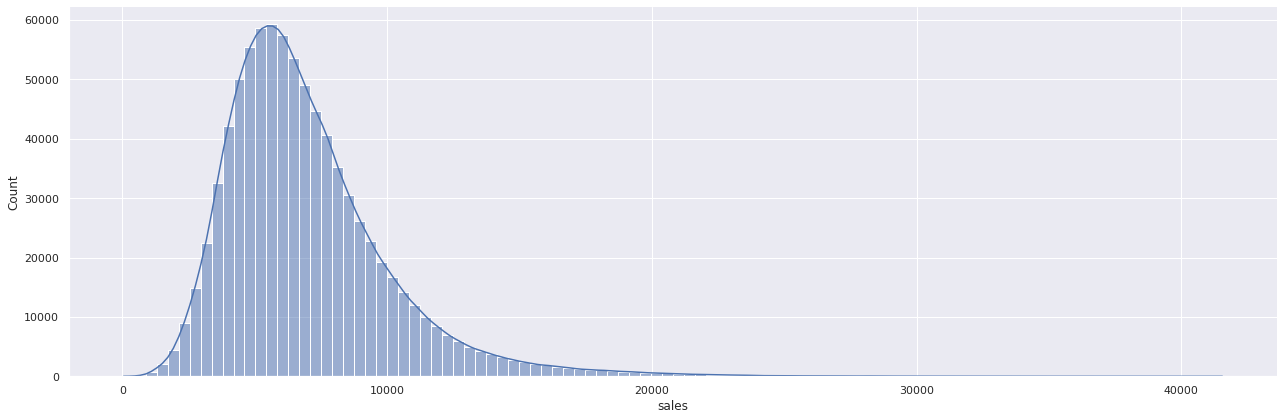

In [40]:
sns.displot(df_eda['sales'], height=6, aspect=3, kde=True, bins=100);

### 5.1.2. Numerical Variables

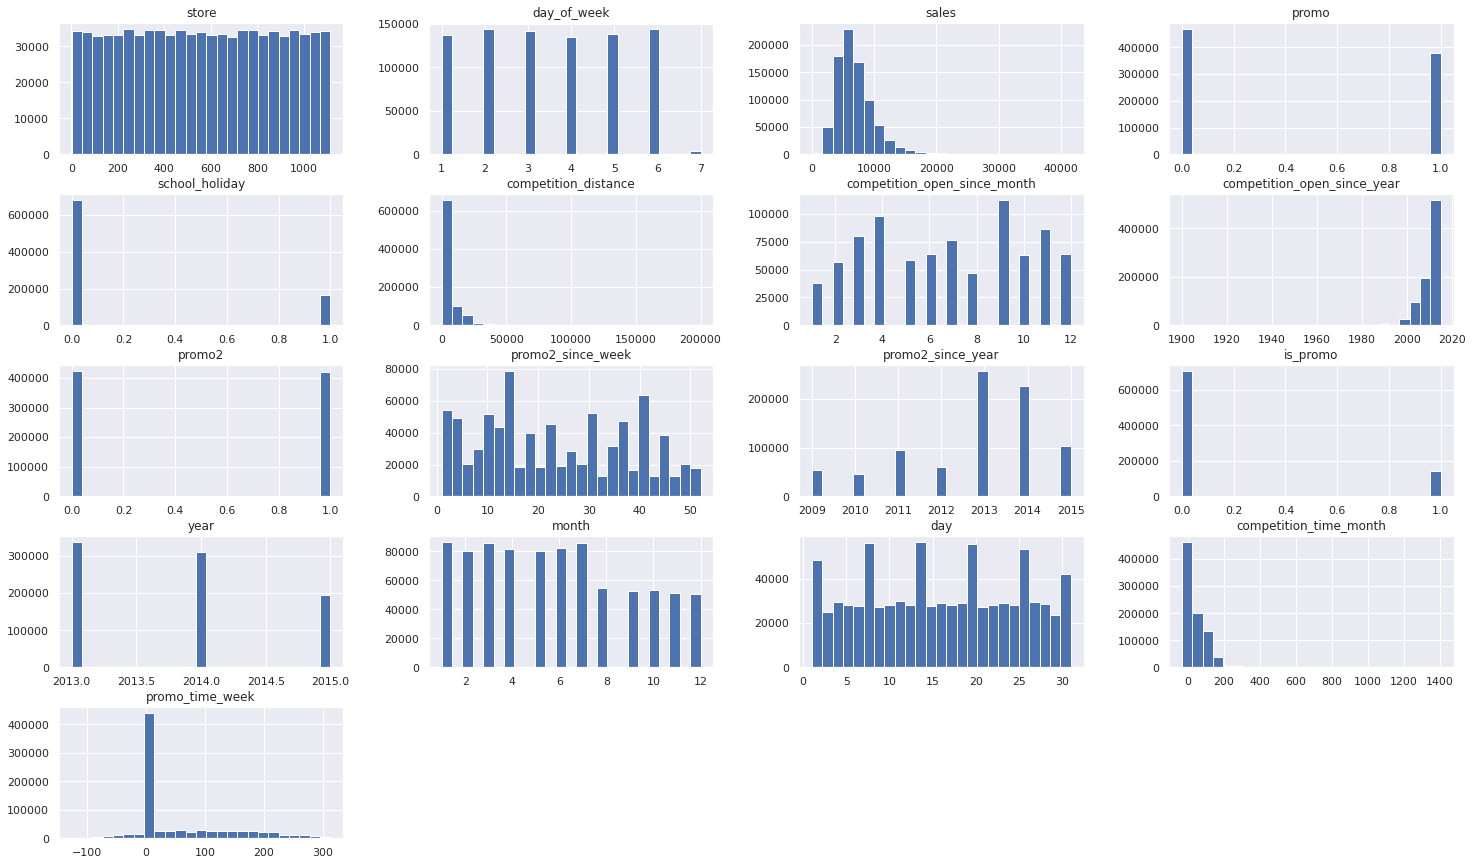

In [41]:
num_attributes.hist(bins=25, figsize=(25,15));

### 5.1.3.Categorical Variables

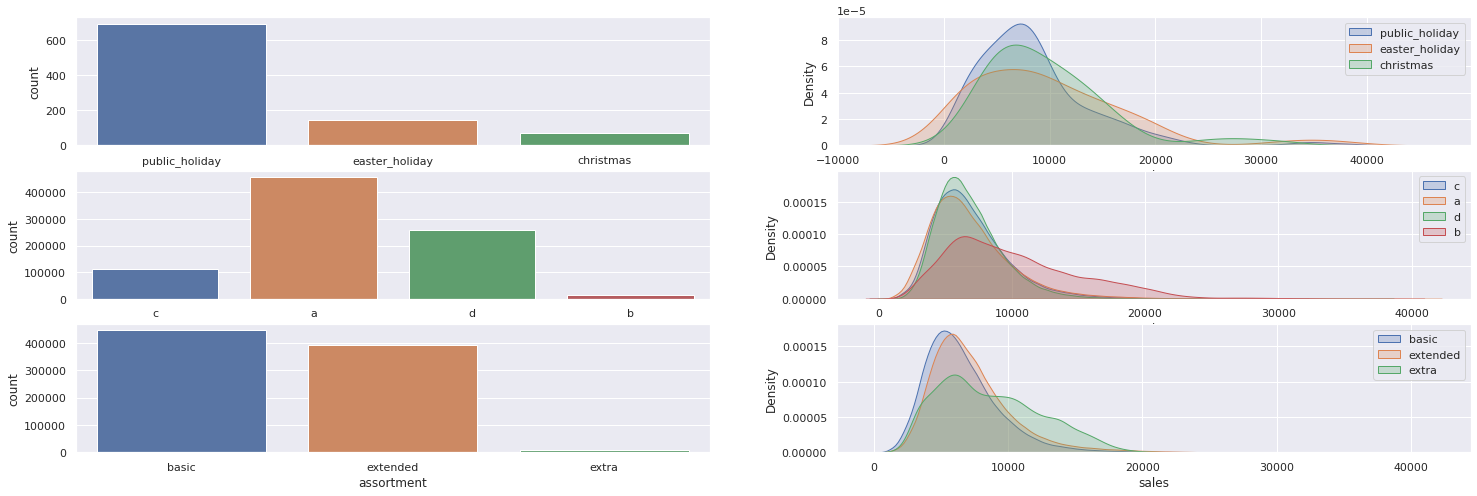

In [42]:
# state_holiday
# as we have a concentration of sales on "regular_day", we will exclude this category for this holiday analysis
plt.subplot(3, 2, 1)
sns.countplot(x='state_holiday', data=df_eda[df_eda['state_holiday'] != 'regular_day'])

fig = plt.subplot(3, 2, 2)
sns.kdeplot(df_eda[df_eda['state_holiday']=='public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df_eda[df_eda['state_holiday']=='easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df_eda[df_eda['state_holiday']=='christmas']['sales'], label='christmas', fill=True);
fig.legend()

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df_eda)

fig = plt.subplot(3, 2, 4)
sns.kdeplot(df_eda[df_eda['store_type']=='c']['sales'], label='c', fill=True)
sns.kdeplot(df_eda[df_eda['store_type']=='a']['sales'], label='a', fill=True)
sns.kdeplot(df_eda[df_eda['store_type']=='d']['sales'], label='d', fill=True)
sns.kdeplot(df_eda[df_eda['store_type']=='b']['sales'], label='b', fill=True)
fig.legend();

# assortment
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df_eda)

fig = plt.subplot(3, 2, 6)
sns.kdeplot(df_eda[df_eda['assortment']=='basic']['sales'], label='basic', fill=True)
sns.kdeplot(df_eda[df_eda['assortment']=='extended']['sales'], label='extended', fill=True)
sns.kdeplot(df_eda[df_eda['assortment']=='extra']['sales'], label='extra', fill=True);
fig.legend();

## 5.2. Bivariate Analysis

### Hypothesis 1. Stores with more assortment should sell more.

**FALSE** Stores with assortment types Basic and Extended have similar total amount of sales, while Extra stores have the lowest total amount of sales. Although, it is fair to mention that stores with assortment type Extra have the highest average sale, the reason they have the lowest total amount of sales in this dataset is due to the different amount of rows of each store type in the dataset 

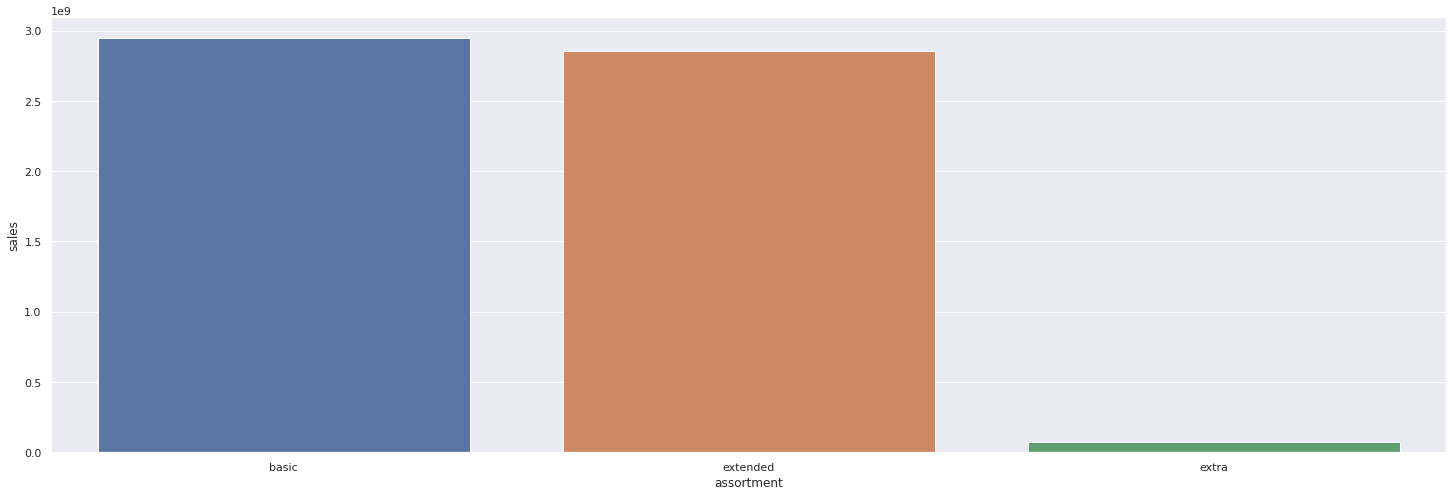

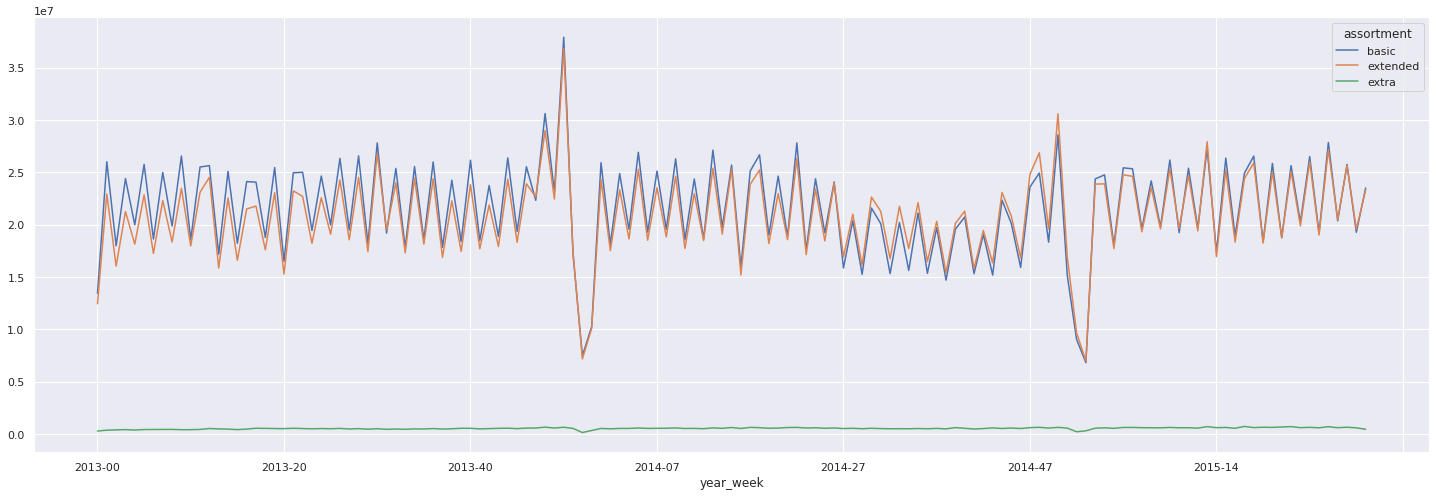

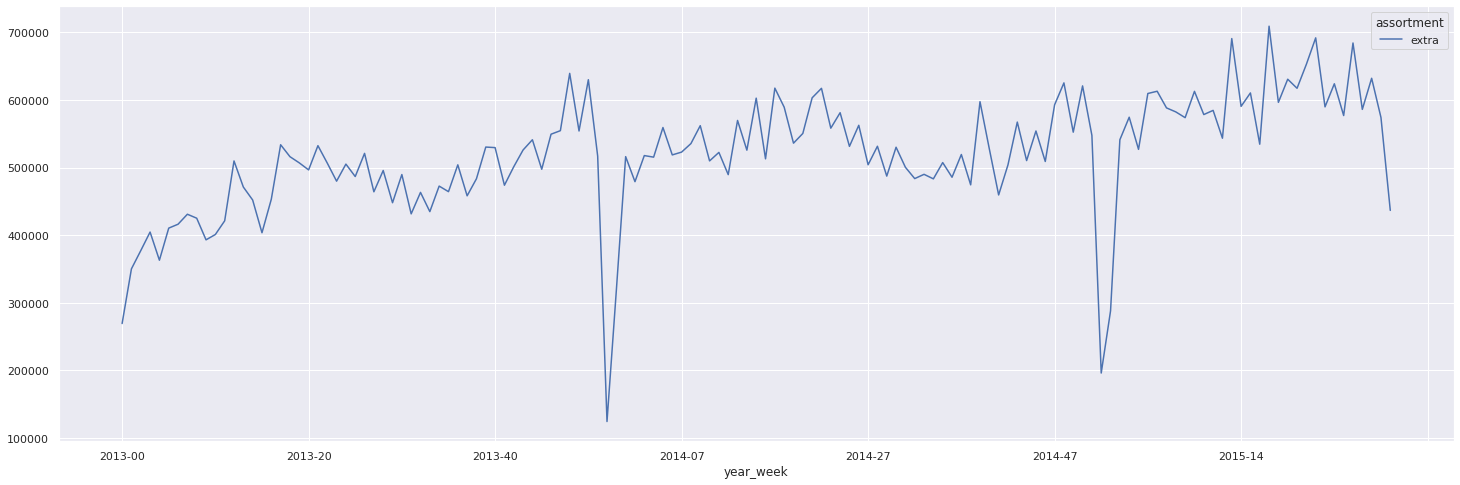

In [43]:
df_h1_aux = df_eda.groupby('assortment')['sales'].sum().reset_index()
sns.barplot(x='assortment', y='sales', data=df_h1_aux);

df_h1_aux = df_eda.groupby(['year_week', 'assortment'])['sales'].sum().reset_index()
df_h1_aux.pivot(index='year_week', columns='assortment', values='sales').plot();

df_h1_aux = df_h1_aux[df_h1_aux['assortment'] == 'extra']
df_h1_aux.pivot(index='year_week', columns='assortment', values='sales').plot();

With these graphs, we can see that the higher volume of sales are from basic and extended stores, both have a very similar sales behaviour. The extra stores have a considerably lower volume of sales, but also have some variance through time. Let's see the average sales amount by store assortment type to check if this behaviour stays the same.

Number of Rows:
Basic: 444875
Extended: 391254
Extra: 8209


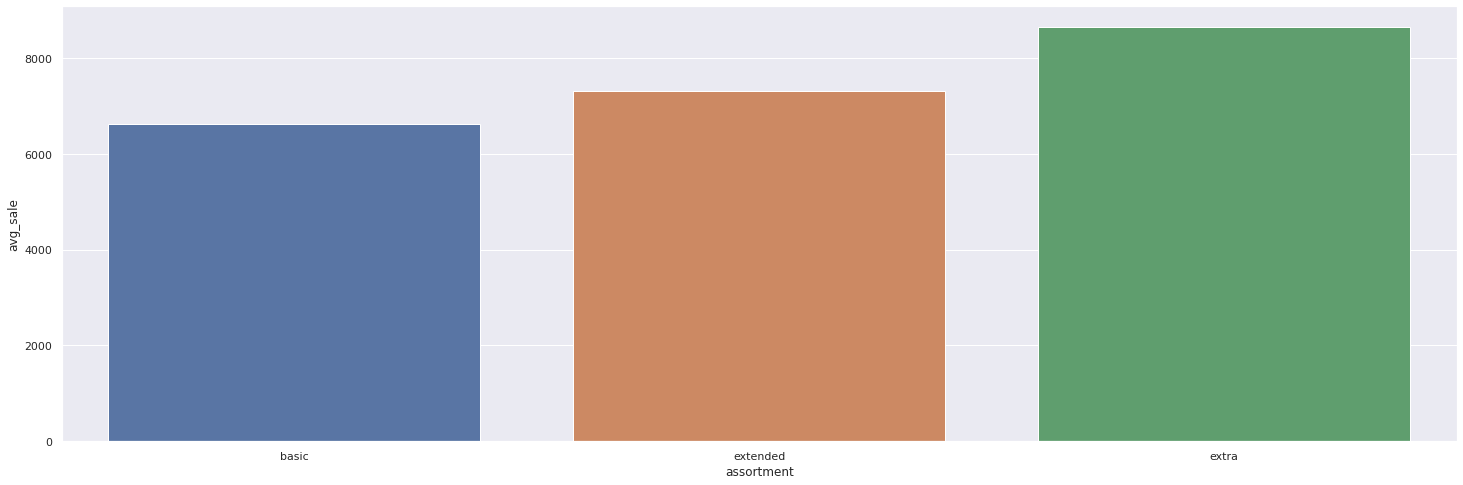

In [44]:
df_h1_aux = df_eda.groupby('assortment')['sales'].sum().reset_index()
count_map = df_eda['assortment'].value_counts().to_dict()
df_h1_aux['count'] = df_h1_aux['assortment'].map(count_map)

print('Number of Rows:\n' + 
      'Basic: ' + str(df_h1_aux['count'][0]) + 
      '\nExtended: ' + str(df_h1_aux['count'][1]) +
      '\nExtra: ' + str(df_h1_aux['count'][2]))

# calculate average sales
df_h1_aux['avg_sale'] = df_h1_aux['sales']/df_h1_aux['count']
sns.barplot(x='assortment', y='avg_sale', data=df_h1_aux);

We can see that Extra assortment type stores have the highest average sale, followed by extended and basic, but have significant less rows on the dataset, which explains the lower total volume of sales.

### Hypothesis 2. Stores with more competitors near should sell less.
**FALSE** Stores with more competitors near sell more

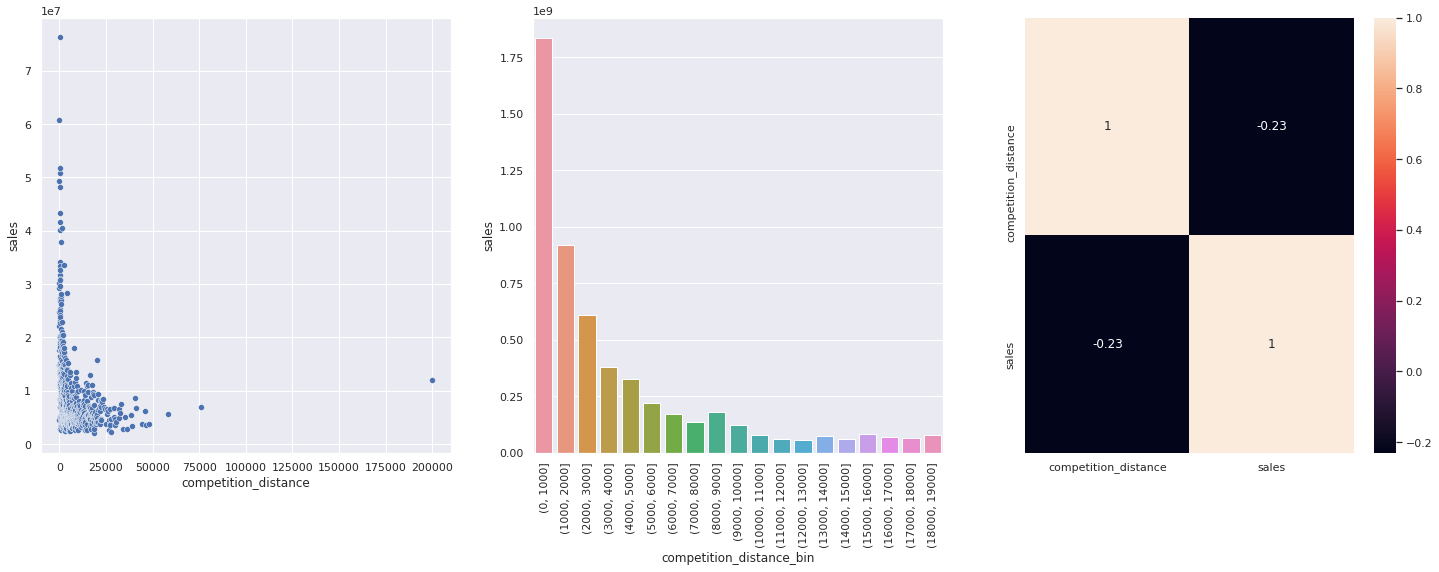

In [45]:
df_h2_aux = df_eda.groupby('competition_distance')['sales'].sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=df_h2_aux);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
df_h2_aux['competition_distance_bin'] = pd.cut(df_h2_aux['competition_distance'], bins=bins)
df_h2_aux2 = df_h2_aux.groupby('competition_distance_bin')['sales'].sum().reset_index()
sns.barplot(x='competition_distance_bin', y='sales', data=df_h2_aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap(df_h2_aux.corr(method='pearson'), annot=True);

We can see that our sales are concentrated on stores with a lower competition distance. The feature competition_distance actually is inversely proportional to the sales variable.

Let's see the average sale by competition distance bin

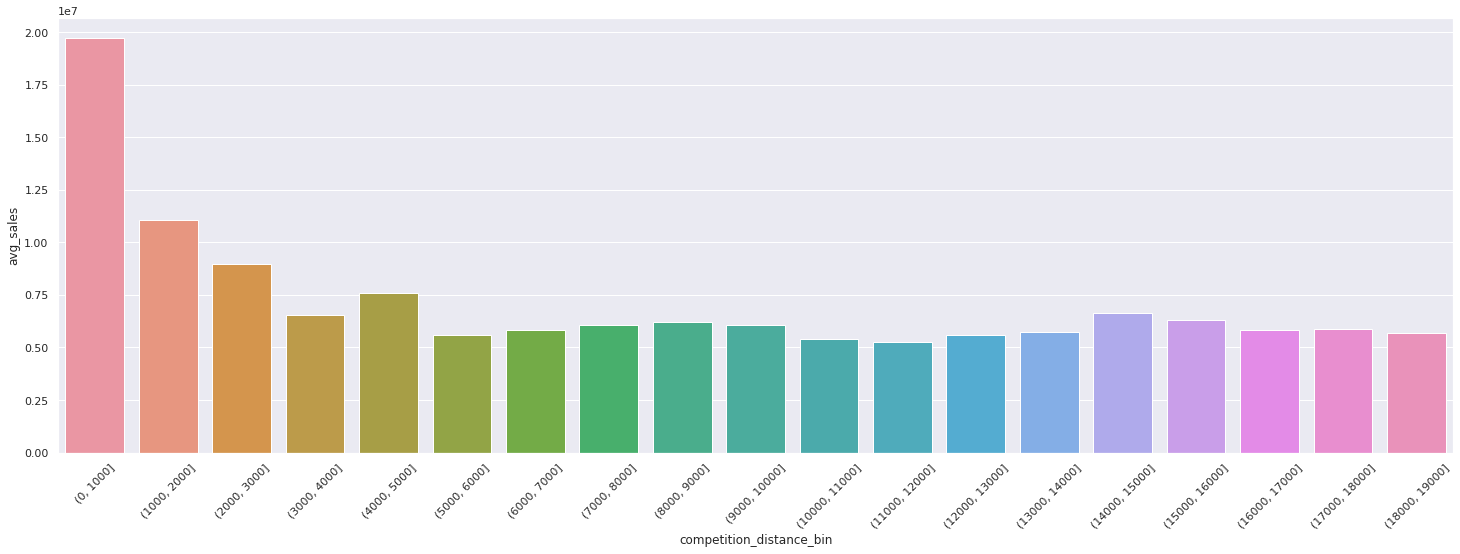

In [46]:
bins = list(np.arange(0, 20000, 1000))
df_h2_aux['competition_distance_bin'] = pd.cut(df_h2_aux['competition_distance'], bins=bins)
df_h2_aux2 = df_h2_aux.groupby('competition_distance_bin')['sales'].sum().reset_index()

count_map = df_h2_aux['competition_distance_bin'].value_counts().to_dict()
df_h2_aux2['count'] = df_h2_aux2['competition_distance_bin'].map(count_map)
df_h2_aux2['avg_sales'] = df_h2_aux2['sales'] / df_h2_aux2['count']

sns.barplot(x='competition_distance_bin', y='avg_sales', data=df_h2_aux2);
plt.xticks(rotation=45);

We can see that the average sale is also higher for stores with a lower competition distance, directing us to the same conclusions from the previous graphs.

### Hypothesis 3. Stores with competitors for longer periods should sell more.
**FALSE** Stores with competitors for longer periods have a lower total amount of sales. Also, if we see the average sale by time of competition, the value is quite stable, showing that it doesn't grow as the competition time gets higher.

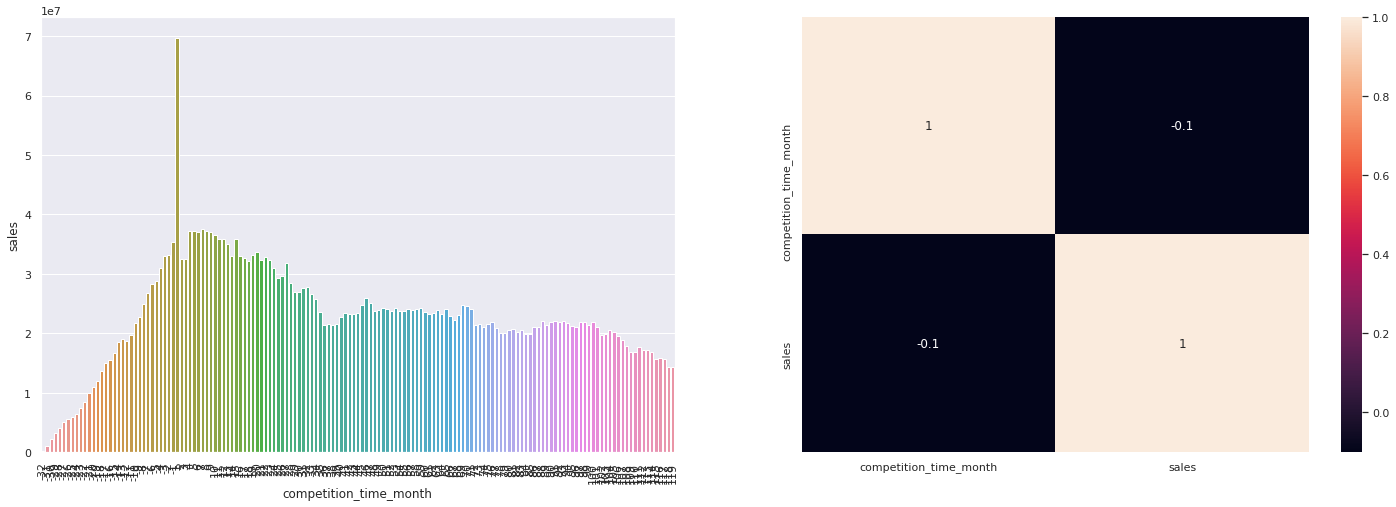

In [47]:
df_h3_aux = df_eda.groupby('competition_time_month')['sales'].sum().reset_index()
# we filter values lower than 120, as there is a huge right tail. And filter values different than 0, because we have a huge peak at this value and it 
# is not of our interest in this moment
df_h3_aux2 = df_h3_aux[(df_h3_aux['competition_time_month'] < 120) & (df_h3_aux['competition_time_month'] != 0)]

plt.subplot(1, 2, 1)
sns.barplot(x='competition_time_month', y='sales', data=df_h3_aux2);
plt.xticks(rotation=90);

plt.subplot(1, 2, 2)
sns.heatmap(df_h3_aux.corr(method='pearson'), annot=True);

We can see that as the months of competition grow, the sales go down. It shows that as more recent the competition is, the higher the sales. Let's see this behaviour on average sales.

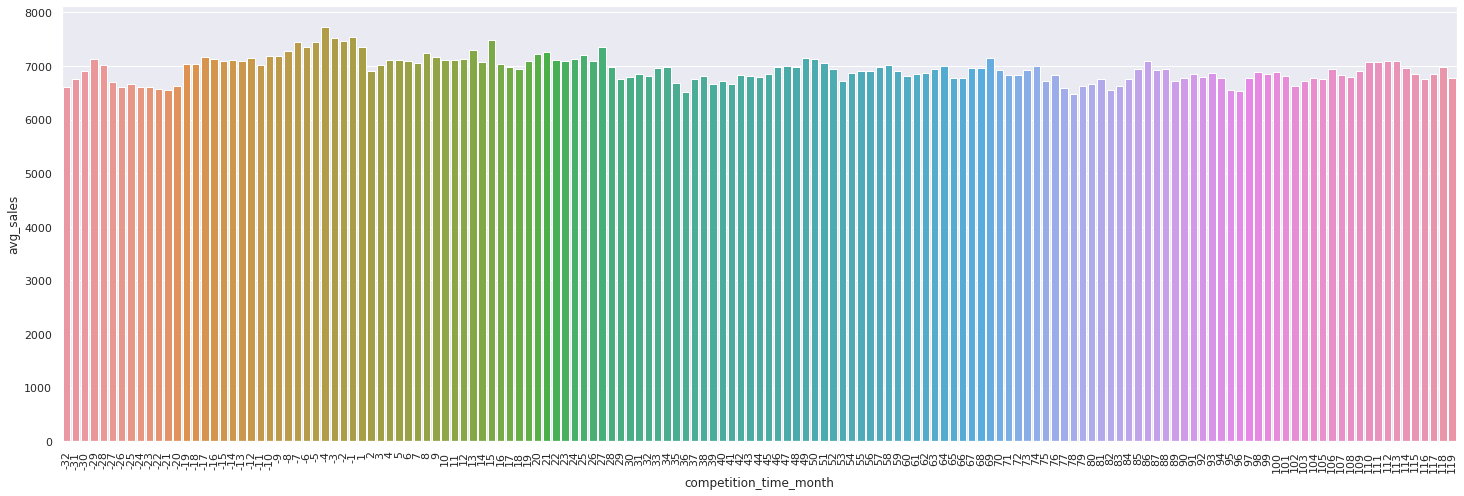

In [48]:
df_h3_aux = df_eda.groupby('competition_time_month')['sales'].sum().reset_index()
count_map = df_eda['competition_time_month'].value_counts().to_dict()
df_h3_aux['count'] = df_h3_aux['competition_time_month'].map(count_map)
df_h3_aux2 = df_h3_aux[(df_h3_aux['competition_time_month'] < 120) & (df_h3_aux['competition_time_month'] != 0)].copy()
df_h3_aux2['avg_sales'] = df_h3_aux2['sales'] / df_h3_aux2['count']

sns.barplot(x='competition_time_month', y='avg_sales', data=df_h3_aux2);
plt.xticks(rotation=90);

This graph shows us that the average sale is quite stable as the time of competition grows, doesn't causing much effect on sales.

### Hypothesis 4. Stores with active promotions for longer periods of time should sell more.
**False** Stores with active promotions for longer periods of time sell less.

For this hypothesis, we will use the promo2 as we only have time period data for this one

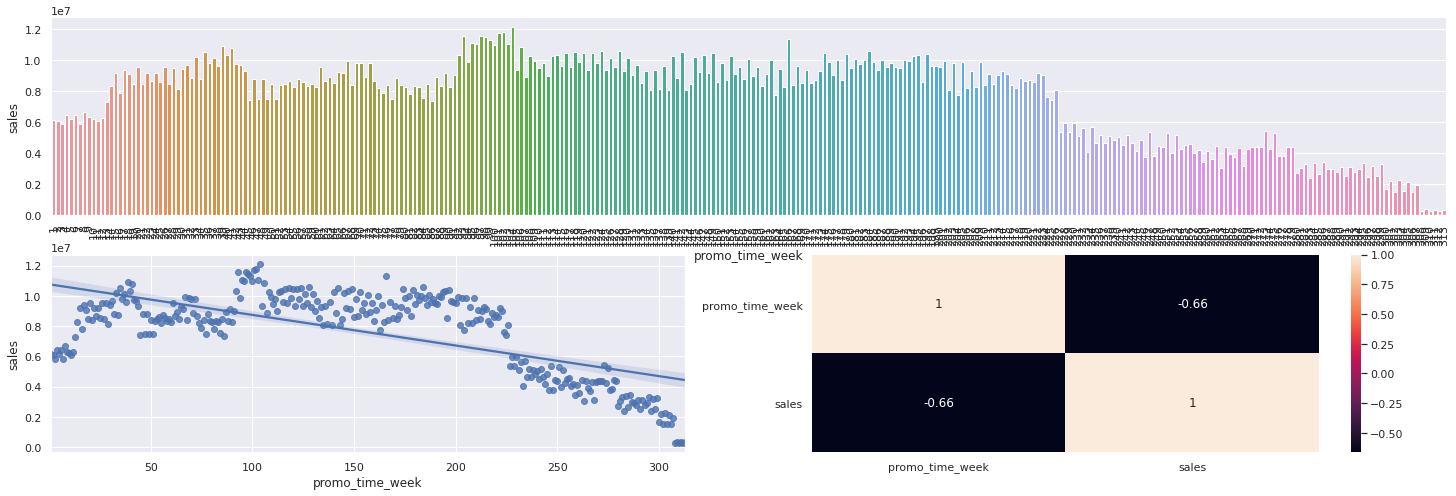

In [49]:
# get only data from the extended promo (promo2)
df_h4_aux = df_eda[(df_eda['promo_time_week'] > 0) & (df_eda['promo2'] == 1)].groupby('promo_time_week')['sales'].sum().reset_index()

grid = GridSpec(2, 2)

plt.subplot(grid[0,:])
sns.barplot(x='promo_time_week', y='sales', data=df_h4_aux);
plt.xticks(rotation=90);

plt.subplot(grid[1,0])
sns.regplot(x='promo_time_week', y='sales', data=df_h4_aux);

plt.subplot(grid[1,1])
sns.heatmap(df_h4_aux.corr(method='pearson'), annot=True);

We can see that sales decrease as the period of promo increases

### Hypothesis 5. Stores with more days of promotion should sell more.
**We will not validate this hypothesis right now, we will let for the next cycle of analysis**

### Hypothesis 6. Stores with more consecutive promotions should sell more.
**We will not validate this hypothesis right now, we will let for the next cycle of analysis**

### Hypothesis 7. Stores opened during Christmas holiday should sell more.
**FALSE** Stores opened during Christmas have a total amount of sales lower than on other holidays. But it is important to notice that the average sales amount of stores on Christmas are higher than on public holidays and regular days, being lower only for stores on Easter.

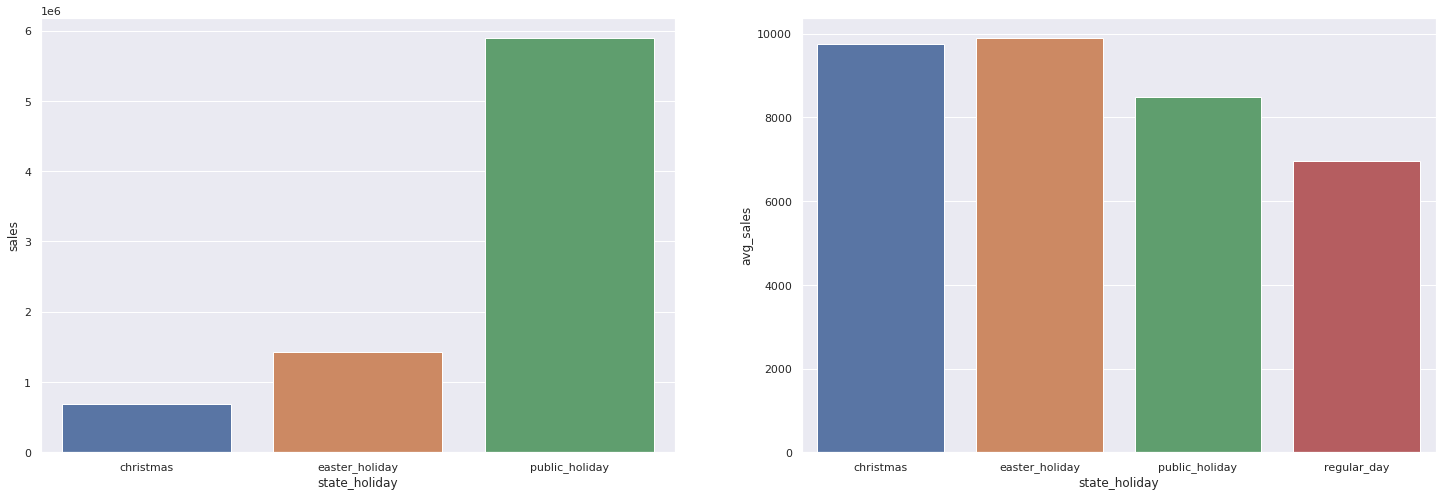

In [50]:
df_h7_aux = df_eda.groupby('state_holiday')['sales'].sum().reset_index()

plt.subplot(1, 2, 1)
# as the total amount of sales during regular days is much higher than sales on holiday, we will filter to see only holidays on this graph
sns.barplot(x='state_holiday', y='sales', data=df_h7_aux[df_h7_aux['state_holiday'] != 'regular_day']);

# lets see the average sales on holiday and regular days
count_map = df_eda['state_holiday'].value_counts().to_dict()
df_h7_aux['count'] = df_h7_aux['state_holiday'].map(count_map)
df_h7_aux['avg_sales'] = df_h7_aux['sales'] / df_h7_aux['count']

plt.subplot(1, 2, 2)
sns.barplot(x='state_holiday', y='avg_sales', data=df_h7_aux);

### Hypothesis 8. Stores should sell more throughout the years.
**FALSE** The total sales amount decreased from one year to the other. Although, it is important to notice that the average sales increased from one year to the other.

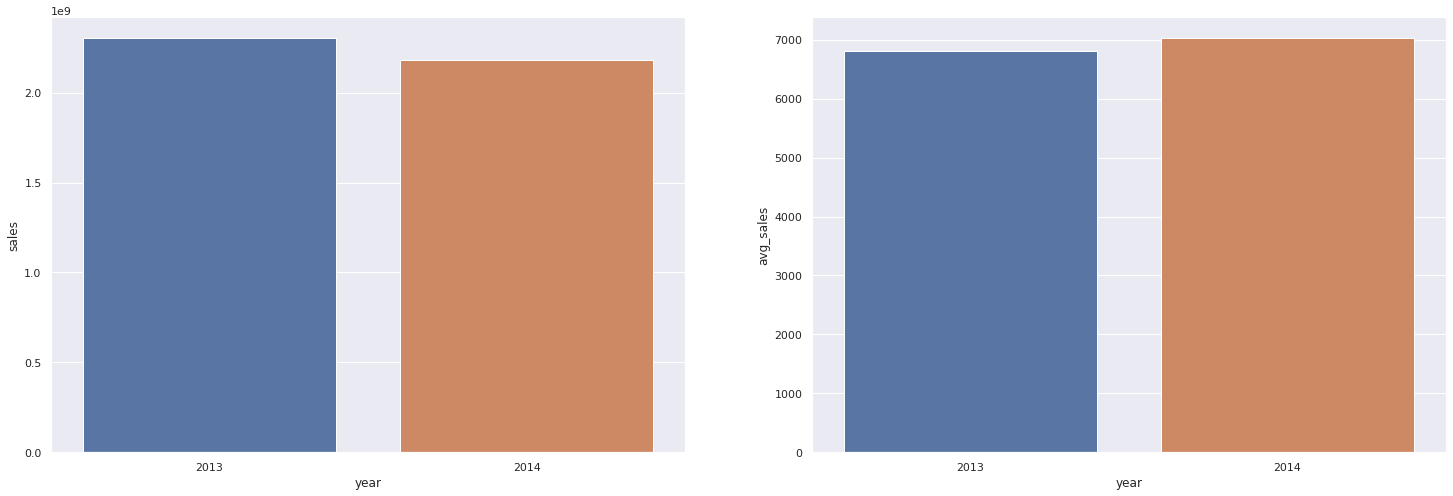

In [51]:
# as the dataset only contains data untill Aug 2015, we will not use this year to analyse as it is not full as the others (2013 and 2014)
df_h8_aux = df_eda[df_eda['year'] != 2015].groupby('year')['sales'].sum().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x='year', y='sales', data=df_h8_aux);

count_map = df_eda['year'].value_counts().to_dict()
df_h8_aux['count'] = df_h8_aux['year'].map(count_map)
df_h8_aux['avg_sales'] = df_h8_aux['sales'] / df_h8_aux['count']
plt.subplot(1, 2, 2)
sns.barplot(x='year', y='avg_sales', data=df_h8_aux);

### Hypothesis 9. Stores should sell more on the second semester of the year.
**FALSE** The total sales amount is very similar between semesters. Although, it is important to notice that the total sales amount and the average sales are higher on December, which explains the slightly higher average sales on the second semester.

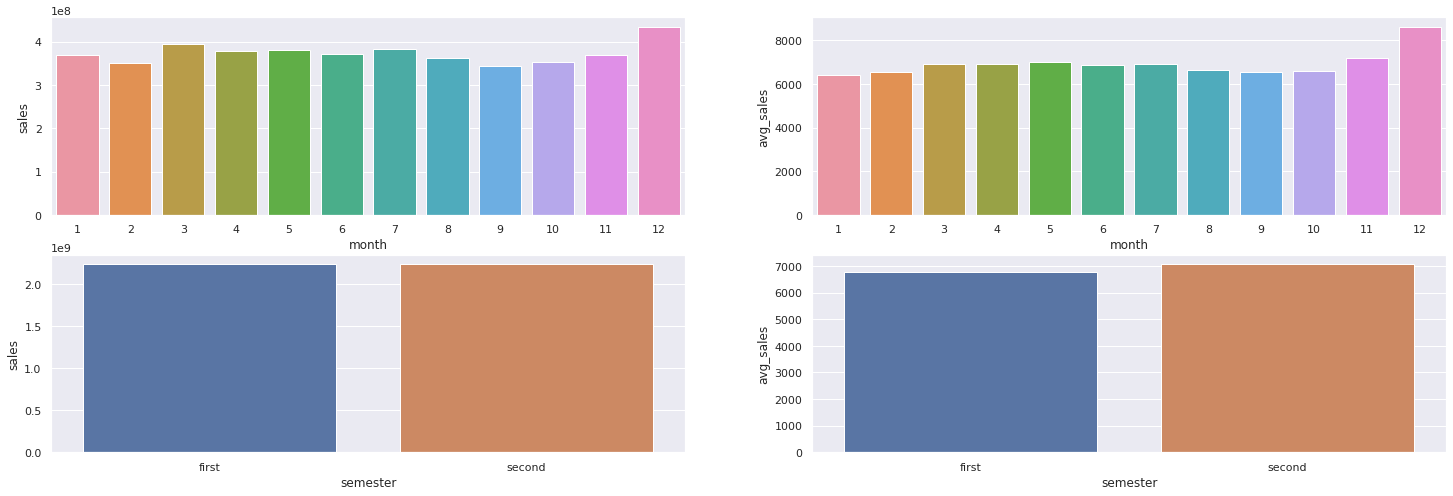

In [52]:
# as the dataset only contains data untill Aug 2015, we will not use this year to analyse as it is not full as the others (2013 and 2014)
df_h9_aux = df_eda[df_eda['year'] != 2015].groupby('month')['sales'].sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='month', y='sales', data=df_h9_aux);

count_map = df_eda[df_eda['year'] != 2015]['month'].value_counts().to_dict()
df_h9_aux['count'] = df_h9_aux['month'].map(count_map)
df_h9_aux['avg_sales'] = df_h9_aux['sales'] / df_h9_aux['count']
plt.subplot(2, 2, 2)
sns.barplot(x='month', y='avg_sales', data=df_h9_aux);

df_h9_aux['semester'] = df_h9_aux['month'].apply(lambda x: 'first' if x < 7 else 'second')
df_h9_aux2 = df_h9_aux.groupby('semester')[['sales', 'count']].sum().reset_index()
df_h9_aux2['avg_sales'] = df_h9_aux2['sales'] / df_h9_aux2['count']

plt.subplot(2, 2, 3)
sns.barplot(x='semester', y='sales', data=df_h9_aux2);
            
plt.subplot(2, 2, 4)
sns.barplot(x='semester', y='avg_sales', data=df_h9_aux2);

### Hypothesis 10. Stores should sell more after the 10th day of each month.
**TRUE** The total sales amount is higher after the 10th day. Although. it is very important to notice that the average sales from the period "before the 10th day" is higher, and the total sales amount of the first 10 days is around 50% of the total sales amount of the remaining 20 days.

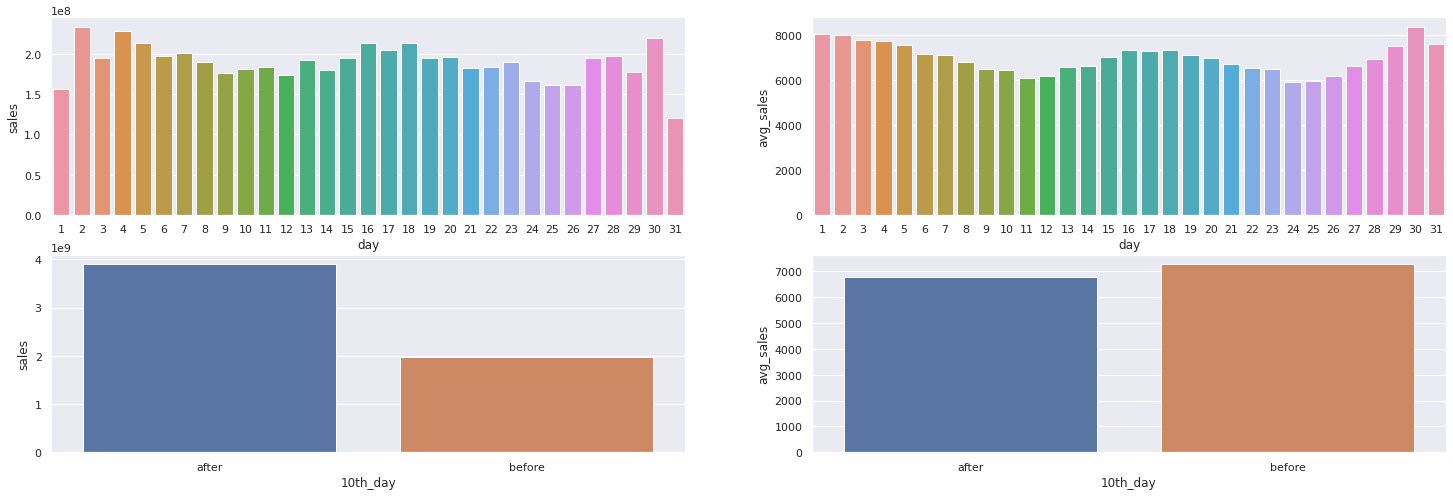

In [53]:
df_h10_aux = df_eda.groupby('day')['sales'].sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=df_h10_aux);

count_map = df_eda['day'].value_counts().to_dict()
df_h10_aux['count'] = df_h10_aux['day'].map(count_map)
df_h10_aux['avg_sales'] = df_h10_aux['sales'] / df_h10_aux['count']
plt.subplot(2, 2, 2)
sns.barplot(x='day', y='avg_sales', data=df_h10_aux);

df_h10_aux['10th_day'] = df_h10_aux['day'].apply(lambda x: 'before' if x <= 10 else 'after')
df_h10_aux2 = df_h10_aux.groupby('10th_day')[['sales', 'count']].sum().reset_index()
df_h10_aux2['avg_sales'] = df_h10_aux2['sales'] / df_h10_aux2['count']

plt.subplot(2, 2, 3)
sns.barplot(x='10th_day', y='sales', data=df_h10_aux2);
            
plt.subplot(2, 2, 4)
sns.barplot(x='10th_day', y='avg_sales', data=df_h10_aux2);

### Hypothesis 11. Stores should sell less on weekends.
**TRUE** Stores sell less on weekends, including the average sales on weekend are lower. It is interesting to notice that the total sales amount for Sundays is very low, but the average sales is one of the highest.

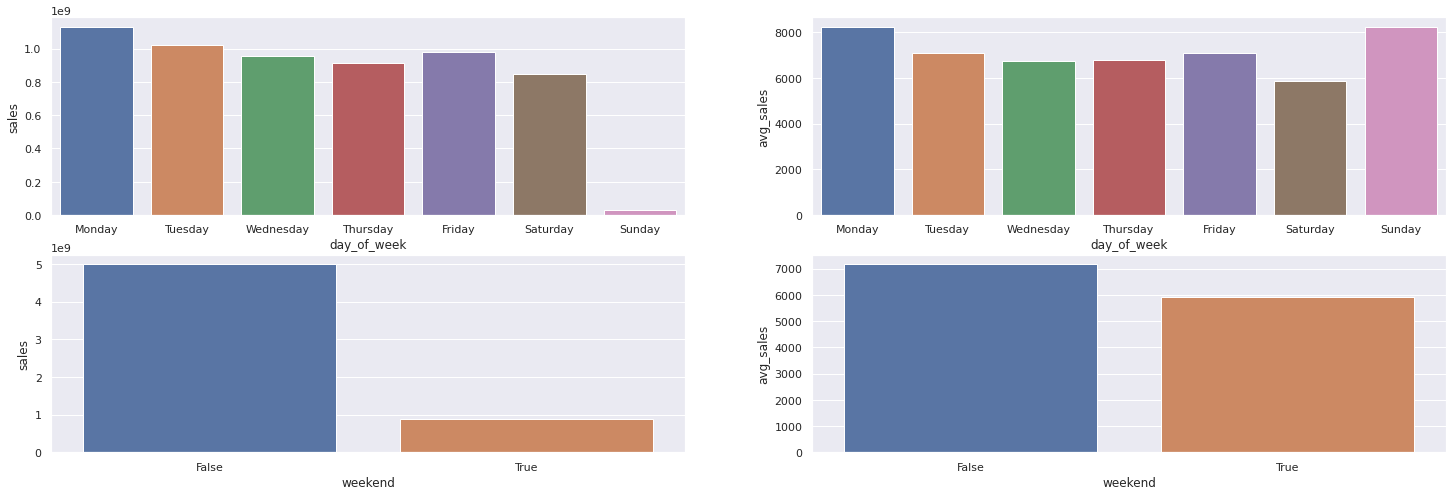

In [54]:
df_h11_aux = df_eda.groupby('day_of_week')['sales'].sum().reset_index()

plt.subplot(2, 2, 1)
g = sns.barplot(x='day_of_week', y='sales', data=df_h11_aux);
g.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

count_map = df_eda['day_of_week'].value_counts().to_dict()
df_h11_aux['count'] = df_h11_aux['day_of_week'].map(count_map)
df_h11_aux['avg_sales'] = df_h11_aux['sales'] / df_h11_aux['count']
plt.subplot(2, 2, 2)
g = sns.barplot(x='day_of_week', y='avg_sales', data=df_h11_aux);
g.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

df_h11_aux['weekend'] = df_h11_aux['day_of_week'].apply(lambda x: True if x >= 6 else False)
df_h11_aux2 = df_h11_aux.groupby('weekend')[['sales', 'count']].sum().reset_index()
df_h11_aux2['avg_sales'] = df_h11_aux2['sales'] / df_h11_aux2['count']

plt.subplot(2, 2, 3)
sns.barplot(x='weekend', y='sales', data=df_h11_aux2);
            
plt.subplot(2, 2, 4)
sns.barplot(x='weekend', y='avg_sales', data=df_h11_aux2);

### Hypothesis 12. Stores should sell less during school holidays.
**TRUE** The total amount of sales in school holidays is lower than on regular days, and it makes sense as there are many more regular days than school holiday thoughout the year. Nevertheless, it is interesting to notice that the average sales on school holidays are higher. And on month 7, the total sales amount is almost equal between school holiday and not school holiday, as on month 8, the total sales amount of school holidays is higher. This can be explained by mid-year vacations, when we have more school holidays.

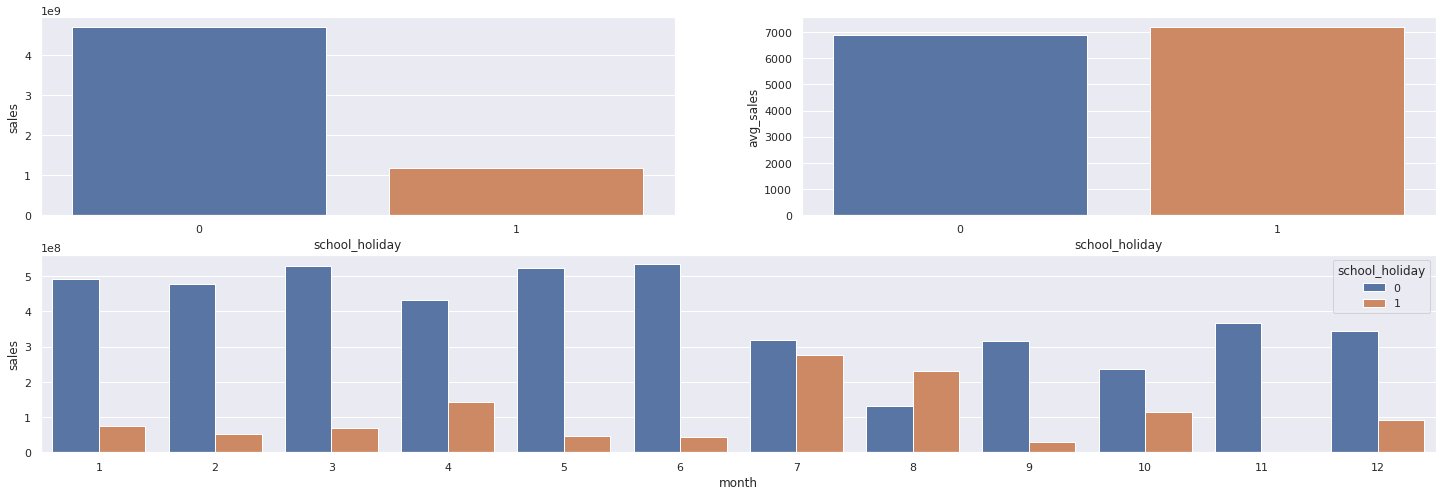

In [55]:
df_h12_aux = df_eda.groupby('school_holiday')['sales'].sum().reset_index()

grid = GridSpec(2, 2)

plt.subplot(grid[0,0])
sns.barplot(x='school_holiday', y='sales', data=df_h12_aux);

count_map = df_eda['school_holiday'].value_counts().to_dict()
df_h12_aux['count'] = df_h12_aux['school_holiday'].map(count_map)
df_h12_aux['avg_sales'] = df_h12_aux['sales'] / df_h12_aux['count']
plt.subplot(grid[0,1])
sns.barplot(x='school_holiday', y='avg_sales', data=df_h12_aux);

df_h12_aux = df_eda.groupby(['month', 'school_holiday'])['sales'].sum().reset_index()
plt.subplot(grid[1,:])
sns.barplot(x='month', y='sales', hue='school_holiday', data=df_h12_aux);

### Hypotheses Overview

In [56]:
tab = [
    ['Hypothesis', 'Conclusion', 'Relevance'],
    ['H1', 'False', 'Medium'],
    ['H2', 'False', 'Medium'],
    ['H3', 'False', 'Low'],
    ['H4', 'False', 'Low'],
    ['H5', '-', '-'],
    ['H6', '-', '-'],
    ['H7', 'False', 'Low'],
    ['H8', 'False', 'High'],
    ['H9', 'False', 'Low'],
    ['H10', 'True', 'Low'],
    ['H11', 'True', 'High'],
    ['H12', 'True', 'Medium'],
]
print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Medium
H2            False         Medium
H3            False         Low
H4            False         Low
H5            -             -
H6            -             -
H7            False         Low
H8            False         High
H9            False         Low
H10           True          Low
H11           True          High
H12           True          Medium


## 5.3. Multivariate Analysis

### 5.3.1. Numerical Attributes

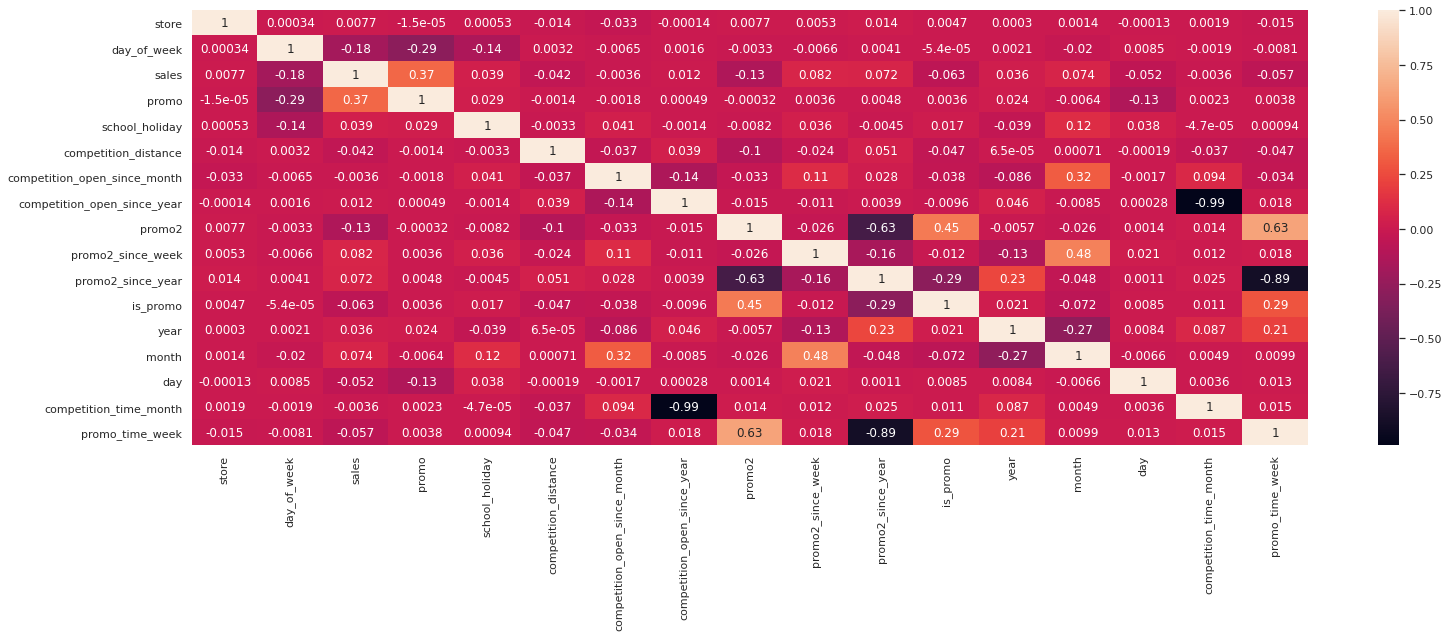

In [57]:
sns.heatmap( num_attributes.corr( method='pearson' ), annot=True );

### 5.3.2. Categorical Attributes

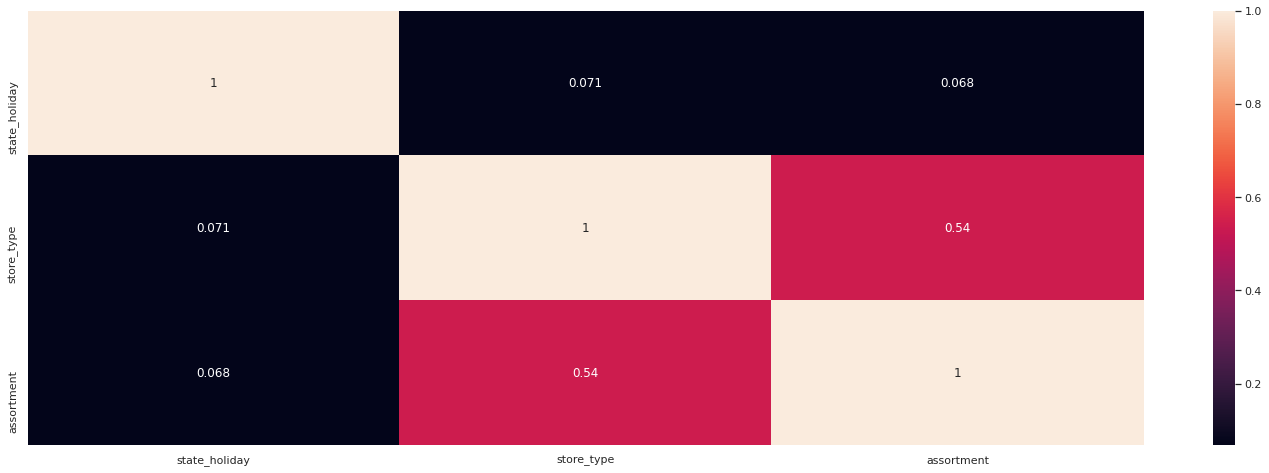

In [58]:
# calculate cramer V
a1 = cramer_v(cat_attributes['state_holiday'], cat_attributes['state_holiday'])
a2 = cramer_v(cat_attributes['state_holiday'], cat_attributes['store_type'])
a3 = cramer_v(cat_attributes['state_holiday'], cat_attributes['assortment'])

a4 = cramer_v(cat_attributes['store_type'], cat_attributes['state_holiday'])
a5 = cramer_v(cat_attributes['store_type'], cat_attributes['store_type'])
a6 = cramer_v(cat_attributes['store_type'], cat_attributes['assortment'])

a7 = cramer_v(cat_attributes['assortment'], cat_attributes['state_holiday'])
a8 = cramer_v(cat_attributes['assortment'], cat_attributes['store_type'])
a9 = cramer_v(cat_attributes['assortment'], cat_attributes['assortment'])

df_results = pd.DataFrame({'state_holiday': [a1, a2, a3],
                           'store_type': [a4, a5, a6],
                           'assortment': [a7, a8, a9]})
df_results = df_results.set_index(df_results.columns)

sns.heatmap(df_results, annot=True);

# 6. Data Preparation

In [59]:
df_dp = df_eda.copy()

## 6.1. Split Dataset

In [60]:
# do a split by time, getting the last 6 weeks as validation set
date_start_validation_set = df_dp.groupby('store')['date'].max().reset_index()['date'][0] - datetime.timedelta(days=42)

# train
x_train = df_dp[df_dp['date'] < date_start_validation_set].copy()
y_train = x_train['sales'].copy()

# validation
x_valid = df_dp[df_dp['date'] >= date_start_validation_set].copy()
y_valid = x_valid['sales'].copy()

print(f"Training Min Date: {x_train['date'].min()}")
print(f"Training Max Date: {x_train['date'].max()}")

print(f"\nValidation Min Date: {x_valid['date'].min()}")
print(f"Validation Min Date: {x_valid['date'].max()}")

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Validation Min Date: 2015-06-19 00:00:00
Validation Min Date: 2015-07-31 00:00:00


## 6.2. Rescaling

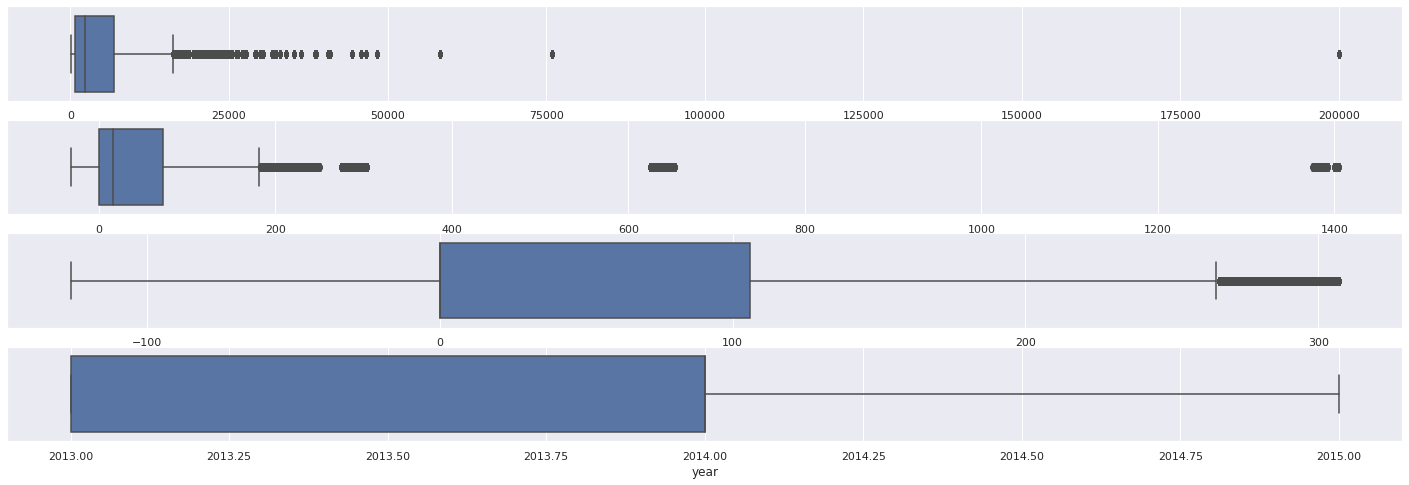

In [61]:
plt.subplot(4, 1, 1)
sns.boxplot(x='competition_distance', data=x_train)

plt.subplot(4, 1, 2)
sns.boxplot(x='competition_time_month', data=x_train)

plt.subplot(4, 1, 3)
sns.boxplot(x='promo_time_week', data=x_train)

plt.subplot(4, 1, 4)
sns.boxplot(x='year', data=x_train);

In [62]:
# for the attributes with a high impact of outliers, we will use Robust Scaler instead of Min Max Scaler
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
x_train['competition_distance'] = rs.fit_transform(x_train[['competition_distance']].values)
pickle.dump(rs, open('deploy/data_transformation/scaler_competition_distance.pkl', 'wb'))

# competition_time_month
x_train['competition_time_month'] = rs.fit_transform(x_train[['competition_time_month']].values)
pickle.dump(rs, open('deploy/data_transformation/scaler_competition_time_month.pkl', 'wb'))

# promo_time_week
x_train['promo_time_week'] = rs.fit_transform(x_train[['promo_time_week']].values)
pickle.dump(rs, open('deploy/data_transformation/scaler_promo_time_week.pkl', 'wb'))

# year
x_train['year'] = mms.fit_transform(x_train[['year']].values)

## 6.3. Transformation

### 6.3.1. Encoding

In [63]:
# state_holiday - One Hot Encoding
x_train = pd.get_dummies(x_train, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Enconding
le = LabelEncoder()
x_train['store_type'] = le.fit_transform(x_train['store_type'])
pickle.dump(le, open('deploy/data_transformation/encoder_store_type.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
x_train['assortment'] = x_train['assortment'].map(assortment_dict)

### 6.3.2. Response Variable Transformation

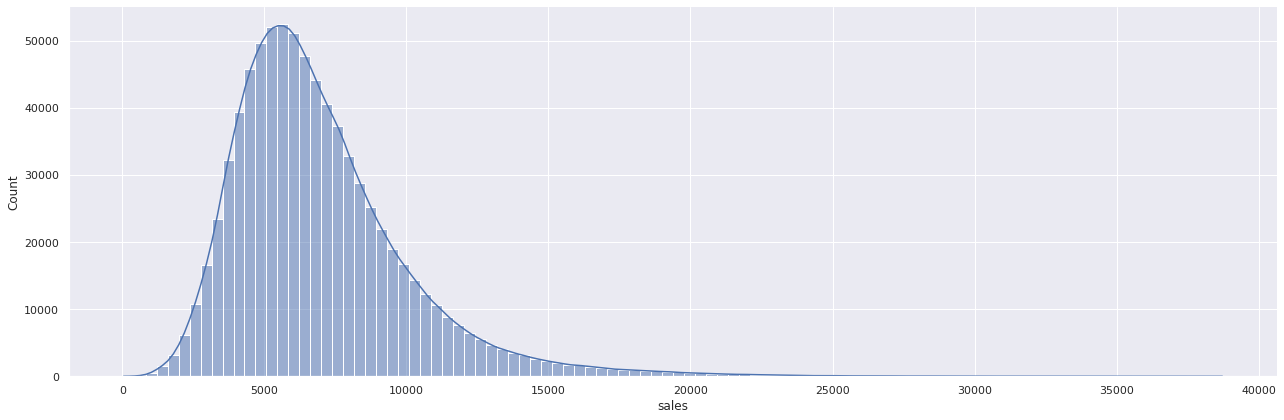

In [64]:
sns.displot(y_train, height=6, aspect=3, kde=True, bins=100);

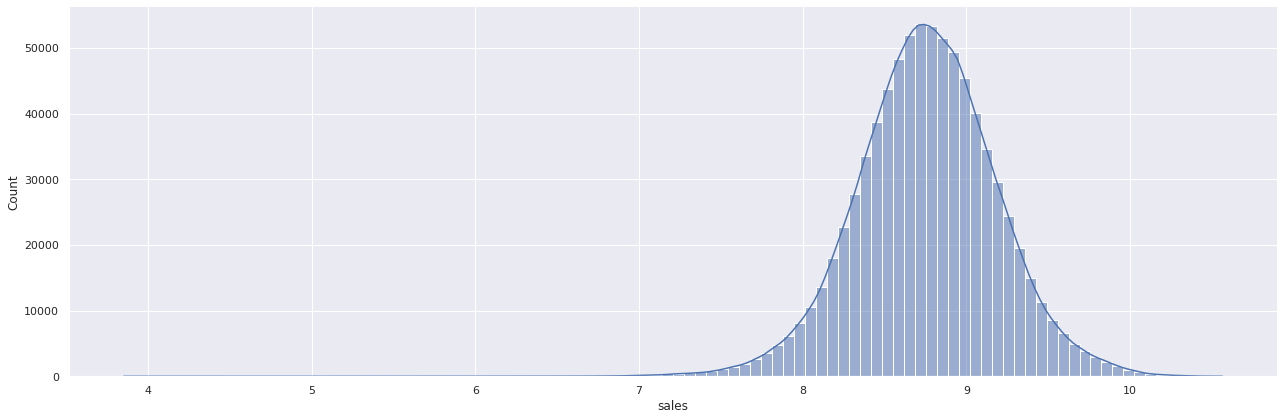

In [65]:
y_train = np.log1p(y_train)
sns.displot(y_train, height=6, aspect=3, kde=True, bins=100);

### 6.3.3. Nature Transformation

In [66]:
# day of week
x_train['day_of_week_sin'] = x_train['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
x_train['day_of_week_cos'] = x_train['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
x_train['month_sin'] = x_train['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
x_train['month_cos'] = x_train['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
x_train['day_sin'] = x_train['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
x_train['day_cos'] = x_train['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
x_train['week_of_year_sin'] = x_train['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
x_train['week_of_year_cos'] = x_train['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# 7. Feature Selection

In [67]:
# drop unecessary columns, already used to create other through feature engineering or transformation
cols_drop = ['day_of_week', 'month', 'day', 'week_of_year', 'year_week', 'competition_since', 'promo_since']
x_train = x_train.drop(cols_drop, axis=1)

## 7.2. Boruta as Feature Selector

In [68]:
# training dataset for boruta
#x_train_n = x_train.drop(['sales','date'], axis=1).values
#y_train_n = y_train.values.ravel()

#rf = RandomForestRegressor(n_jobs=-1)
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

### 7.2.1. Best Features by Boruta

In [69]:
#cols_selected = boruta.support_.tolist()

#x_train_fs = x_train.drop(['sales'], axis=1)
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

In [70]:
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 
                        'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos',
                        'day_sin', 'day_cos', 'week_of_year_cos']
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [71]:
cols_not_selected_boruta = ['is_promo', 'month_sin', 'school_holiday', 'state_holiday_christmas',
                            'state_holiday_easter_holiday', 'state_holiday_public_holiday', 'state_holiday_regular_day',
                            'week_of_year_sin', 'year']
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

Now let's compare the features selected by Boruta with the features we classified as relevant during the EDA.

In [72]:
tab = [
    ['Hypothesis', 'Conclusion', 'Relevance'],
    ['H1', 'False', 'Medium'],
    ['H2', 'False', 'Medium'],
    ['H3', 'False', 'Low'],
    ['H4', 'False', 'Low'],
    ['H5', '-', '-'],
    ['H6', '-', '-'],
    ['H7', 'False', 'Low'],
    ['H8', 'False', 'High'],
    ['H9', 'False', 'Low'],
    ['H10', 'True', 'Low'],
    ['H11', 'True', 'High'],
    ['H12', 'True', 'Medium'],
]
print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Medium
H2            False         Medium
H3            False         Low
H4            False         Low
H5            -             -
H6            -             -
H7            False         Low
H8            False         High
H9            False         Low
H10           True          Low
H11           True          High
H12           True          Medium


High Relevance
* The hypothesis 8 is related to the feature year, which was not selected by Boruta
* The hypothesis 11 is related to the feature day_of_week, which was selected by Boruta

Medium Relevance
* The hypothesis 1 is related to the feature assortment, which was selected by Boruta
* The hypothesis 2 is related to the feature competition_distance. which was selected by Boruta
* The hypothesis 12 is related to the feature school_holidays, which was not selected by Boruta

With these validation, we will create a list of chosen features. The feature school_holidays, for example, will be left out, but could be tested in a future cycle.

### 7.2.2. Manual Feature Selection
Based on Boruta output and the EDA results, we will manually select the features. This will save us from needing to run Boruta every time we run this notebook.

In [73]:
features_selected = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# 8. Machine Learning Modelling

In [74]:
train = x_train.copy()
x_train = train[features_selected]

# get raw train dataset to do data transformation inside cross validation
# do a split by time, getting the last 6 weeks as validation set
date_start_validation_set = df_dp.groupby('store')['date'].max().reset_index()['date'][0] - datetime.timedelta(days=42)

# train
train_cv = df_dp[df_dp['date'] < date_start_validation_set].copy()

## 8.1. Transform Validation set

In [75]:
# data transformation on validation data
# competition_distance - Robust Scaler
competition_distance_scaler = pickle.load(open('deploy/data_transformation/scaler_competition_distance.pkl', 'rb'))
x_valid['competition_distance'] = competition_distance_scaler.transform(x_valid[['competition_distance']].values)

# competition_time_month - RObust Scaler
competition_time_month_scaler = pickle.load(open('deploy/data_transformation/scaler_competition_time_month.pkl', 'rb'))
x_valid['competition_time_month'] = competition_time_month_scaler.transform(x_valid[['competition_time_month']].values)

# promo_time_week - Robust Scaler
promo_time_week_scaler = pickle.load(open('deploy/data_transformation/scaler_promo_time_week.pkl', 'rb'))
x_valid['promo_time_week'] = promo_time_week_scaler.transform(x_valid[['promo_time_week']].values)

# store_type - Label Enconding
store_type_encoder = pickle.load(open('deploy/data_transformation/encoder_store_type.pkl', 'rb'))
x_valid['store_type'] = store_type_encoder.transform(x_valid['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
x_valid['assortment'] = x_valid['assortment'].map(assortment_dict)

# day of week
x_valid['day_of_week_sin'] = x_valid['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
x_valid['day_of_week_cos'] = x_valid['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
x_valid['month_sin'] = x_valid['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
x_valid['month_cos'] = x_valid['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
x_valid['day_sin'] = x_valid['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
x_valid['day_cos'] = x_valid['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
x_valid['week_of_year_sin'] = x_valid['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
x_valid['week_of_year_cos'] = x_valid['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

## 8.1. Average (Baseline)

In [76]:
aux_validation = x_valid[['store', 'sales']].copy()
aux_train = train[['store', 'sales']].copy()

aux_pred = aux_train.groupby('store')['sales'].mean().to_dict()
aux_validation['prediction'] = aux_validation['store'].map(aux_pred)

# performance
results_avg = errors_calculator('Average', aux_validation['sales'], aux_validation['prediction'])
results_avg

,Model,MAE,MAPE,RMSE
0,Average,1440.360095,0.227721,1916.544163


In [77]:
validation = x_valid.copy()
# keep only selected features to use on ML models
features_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                     'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                     'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
                     'week_of_year_sin', 'week_of_year_cos']

x_valid = x_valid[features_selected]

## 8.2. Linear Regression

In [78]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat = lr.predict(x_valid)

# performance
results_lr = errors_calculator('Linear Regression', y_valid, np.expm1(yhat))
results_lr

,Model,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 8.2.1. Cross Validation

In [79]:
results_lr_cv = cross_validation(train_cv, 5, lr, 'Linear Regression', True)
results_lr_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 8.3. Linear Regression Regularized - Lasso

In [80]:
# model
lasso = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat = lasso.predict(x_valid)

# performance
results_lasso = errors_calculator('Lasso', y_valid, np.expm1(yhat))
results_lasso

,Model,MAE,MAPE,RMSE
0,Lasso,1891.704881,0.289106,2744.451737


### 8.3.1. Cross Validation

In [81]:
results_lasso_cv = cross_validation(train_cv, 5, lasso, 'Lasso')
results_lasso_cv

,Model,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 8.4. Random Forest

In [82]:
# run only once
# # model
# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# # prediction
# yhat = rf.predict(x_valid)

# # performance
# results_rf = errors_calculator('Random Forest', y_valid, np.expm1(yhat))
# results_rf

In [83]:
results_rf = pd.DataFrame({
    'Model': 'Random Forest',
    'MAE': 679.0208,
    'MAPE': 0.0998,
    'RMSE': 1010.0457 
}, index=[0])
results_rf

,Model,MAE,MAPE,RMSE
0,Random Forest,679.0208,0.0998,1010.0457


### 8.4.1. Cross Validation

In [84]:
# commented so it doesnt run every time
#results_rf_cv = cross_validation(train_cv, 5, rf, 'Random Forest', verbose=True)
#results_rf_cv
results_rf_cv = pd.DataFrame({
    'Model': 'Random Forest',
    'MAE CV': '837.6 +/- 219.14',
    'MAPE CV': '0.12 +/- 0.02',
    'RMSE CV': '1256.44 +/- 320.13'
}, index=[0])
results_rf_cv

,Model,MAE CV,MAPE CV,RMSE CV
0,Random Forest,837.6 +/- 219.14,0.12 +/- 0.02,1256.44 +/- 320.13


## 8.5. XGBoost

In [85]:
# model
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', eta=0.01, n_estimators=100).fit(x_train, y_train)

# prediction
yhat = xgb_reg.predict(x_valid)

# performance
results_xgb = errors_calculator('XGBoost', y_valid, np.expm1(yhat))
results_xgb

,Model,MAE,MAPE,RMSE
0,XGBoost,6684.753754,0.949025,7335.381371


### 8.5.1. Cross Validation

In [86]:
# run only once
# results_xgb_cv = cross_validation(train_cv, 5, xgb_reg, 'XGBoost', verbose=True)
results_xgb_cv = pd.DataFrame({
    'Model': 'XGBoost',
    'MAE CV': '7049.34 +/- 589.28',
    'MAPE CV': '0.95 +/- 0.0',
    'RMSE CV': '7718.57 +/- 689.68'
}, index=[0])
results_xgb_cv

,Model,MAE CV,MAPE CV,RMSE CV
0,XGBoost,7049.34 +/- 589.28,0.95 +/- 0.0,7718.57 +/- 689.68


## 8.6. Compare Model's Results

In [87]:
models_results = pd.concat([results_avg, results_lr, results_lasso, results_rf, results_xgb])
models_results.sort_values('RMSE')

,Model,MAE,MAPE,RMSE
0,Random Forest,679.020800,0.099800,1010.045700
0,Average,1440.360095,0.227721,1916.544163
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Lasso,1891.704881,0.289106,2744.451737
0,XGBoost,6684.753754,0.949025,7335.381371


### 8.6.1. Cross Validation Results

In [88]:
models_results_cv = pd.concat([results_lr_cv, results_lasso_cv, results_rf_cv, results_xgb_cv])
models_results_cv

,Model,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest,837.6 +/- 219.14,0.12 +/- 0.02,1256.44 +/- 320.13
0,XGBoost,7049.34 +/- 589.28,0.95 +/- 0.0,7718.57 +/- 689.68


# 9. Hyperparameter Tuning

Despite XGBoost having the worst results on the last phase, we will do the hyperparameter tuning to find better parameters for this model also, as we know that this model should have better results, probably the default parameters werent good for this problem.

## 9.1. Random Search - XGBoost

In [89]:
# only run once
# params = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
# }

# MAX_EVAL = 5

# final_results = pd.DataFrame()
# for i in range(MAX_EVAL):
#     # choose randomly each parameter value
#     hyper_params = {k: random.sample(v, 1)[0] for k, v in params.items()}
#     print(hyper_params)
   
#     # model
#     xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', 
#                                n_estimators=hyper_params['n_estimators'],
#                                eta=hyper_params['eta'], 
#                                max_depth=hyper_params['max_depth'],
#                                subsample=hyper_params['subsample'],
#                                colsample_bytree=hyper_params['colsample_bytree'],
#                                min_child_weight=hyper_params['min_child_weight'])
#     # performance
#     results = cross_validation(train_cv, 5, xgb_reg, 'XGBoost', verbose=True)
#     final_results = pd.concat([final_results, results])
    
# final_results

Best Parameters found:
'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3

Respective results of Cross Validation:
* MAE: 811 +/- 115.47
* MAPE: 0.11 +/- 0.01
* RMSE: 1162.89 +/- 161.64

## 9.2. Final Model

In [90]:
# only run once
# best parameters found by Random Search
# hyper_params = {
#     'n_estimators': 3500, 
#     'eta': 0.03, 
#     'max_depth': 9, 
#     'subsample': 0.1, 
#     'colsample_bytree': 0.7, 
#     'min_child_weight': 3
# }

# # model
# xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', 
#                        n_estimators=hyper_params['n_estimators'],
#                        eta=hyper_params['eta'], 
#                        max_depth=hyper_params['max_depth'],
#                        subsample=hyper_params['subsample'],
#                        colsample_bytree=hyper_params['colsample_bytree'],
#                        min_child_weight=hyper_params['min_child_weight']).fit(x_train, y_train)

# # prediction
# yhat = xgb_reg.predict(x_valid)

# # performance
# results = errors_calculator('XGBoost', y_valid, np.expm1(yhat))
# results

Results from model with hyperparameters tuned:
* MAE: 646.4594
* MAPE: 0.0936
* RMSE: 939.4398

In [91]:
# mpe = mean_percentage_error(y_valid, np.expm1(yhat))
# mpe

MPE (Mean Percentage Error): 0.0056

In [92]:
# save model in a pickle object
# model_file = open('deploy/model/xgb_reg_model.pkl', 'wb')
# pickle.dump(xgb_reg, model_file)

# 10. Error Translation and Interpretation

In [93]:
# load model
model_file = open('deploy/model/xgb_reg_model.pkl', 'rb')
xgb_reg = pickle.load(model_file)

In [94]:
# get validation data to interpret the error and translate it to business performance
# calculate predictions
yhat = xgb_reg.predict(x_valid)

# we will use the selected features + sales and date to analyze through time
features_selected.extend(['sales', 'date'])
valid_extended = validation[features_selected].copy()

valid_extended['predictions'] = np.expm1(yhat)

## 10.1. Business Performance

In [95]:
# sum of sales and predictions by store, and count of dates of sale
df_results_by_store = valid_extended[['store', 'sales', 'predictions', 'date']].groupby('store').agg({
    'predictions': 'sum',
    'sales': 'sum',
    'date': 'count'
}).reset_index().rename(columns={'date': 'count_sales'})
df_results_by_store['predictions'] = df_results_by_store['predictions'].astype(float64)

# calculate MAE and MAPE error by sale by store
df_mae_by_store = valid_extended[['store', 'sales', 'predictions']].groupby('store').apply(
    lambda x: mean_absolute_error(x['sales'], x['predictions'])
)
df_mape_by_store = valid_extended[['store', 'sales', 'predictions']].groupby('store').apply(
    lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])
)
df_results_by_store['MAE_by_sale'] = df_results_by_store['store'].map(df_mae_by_store.to_dict())
df_results_by_store['MAPE_by_sale'] = df_results_by_store['store'].map(df_mape_by_store.to_dict())

# scenarios
df_results_by_store['worst_scenario'] = df_results_by_store['predictions'] - (df_results_by_store['MAE_by_sale'] * df_results_by_store['count_sales'])
df_results_by_store['best_scenario'] = df_results_by_store['predictions'] + (df_results_by_store['MAE_by_sale'] * df_results_by_store['count_sales'])

# order columns
df_results_by_store = df_results_by_store[['store', 'sales', 'count_sales', 'MAE_by_sale', 'MAPE_by_sale', 'predictions', 'worst_scenario', 'best_scenario']]
df_results_by_store.head()

,store,sales,count_sales,MAE_by_sale,MAPE_by_sale,predictions,worst_scenario,best_scenario
0,1,162320,37,272.095848,0.062502,162131.062500,152063.516113,172198.608887
1,2,182936,37,377.690120,0.081263,174622.187500,160647.653076,188596.721924
2,3,254190,37,519.832929,0.073815,260206.046875,240972.228516,279439.865234
3,4,369378,37,919.351061,0.087397,340955.937500,306939.948242,374971.926758
4,5,166905,37,359.551553,0.081095,172068.890625,158765.483154,185372.298096


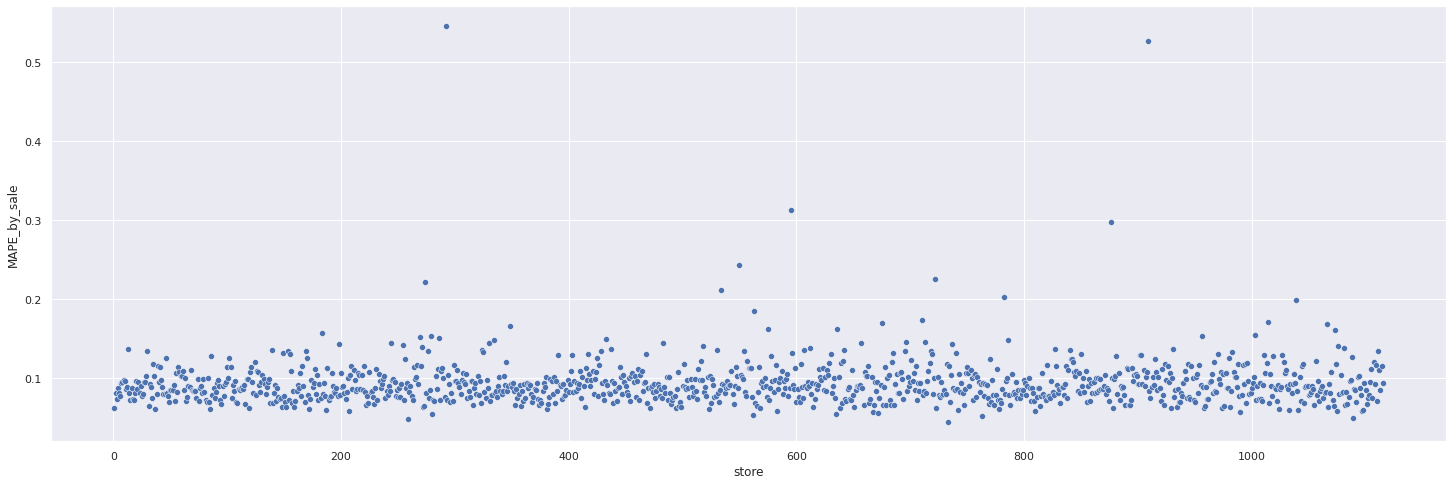

In [96]:
sns.scatterplot(x='store', y='MAPE_by_sale', data=df_results_by_store);

## 10.2. Machine Learning Performance

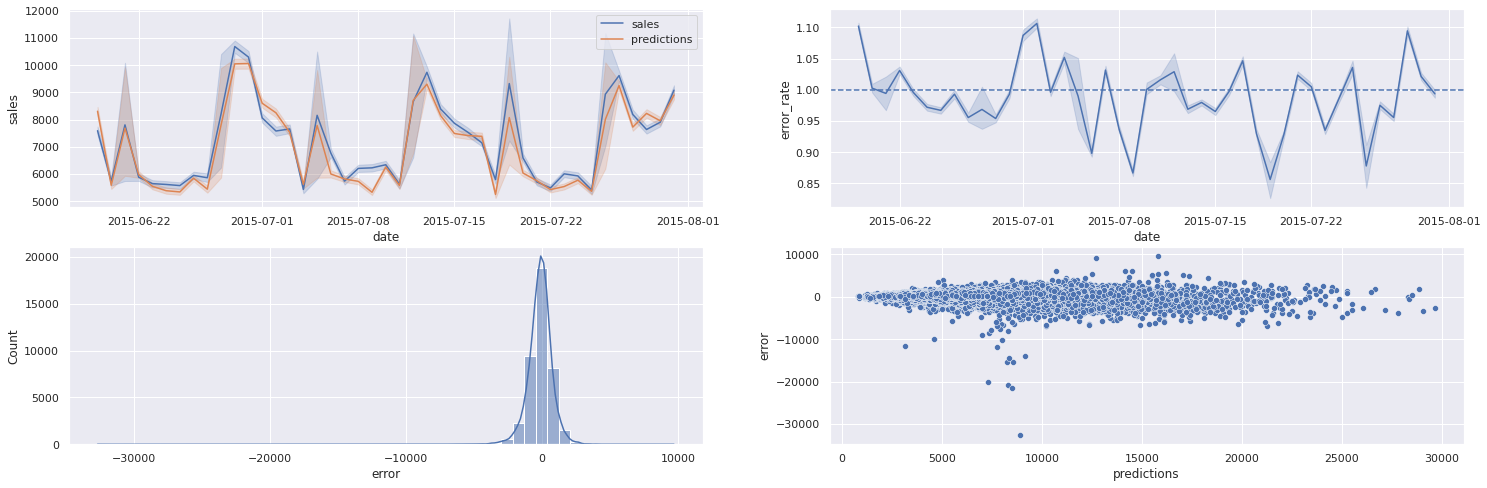

In [105]:
valid_extended['error'] = valid_extended['predictions'] - valid_extended['sales']
valid_extended['error_rate'] = valid_extended['predictions'] / valid_extended['sales']

plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=valid_extended, label='sales')
sns.lineplot(x='date', y='predictions', data=valid_extended, label='predictions')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=valid_extended)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.histplot(valid_extended['error'], kde=True, bins=50)

plt.subplot(2, 2, 4)
sns.scatterplot(x='predictions', y='error', data=valid_extended);

# 11. Deploy

## 11.1. API Tester

In [106]:
# import necessary libraries
import json
import requests

# load test dataset
df_test_raw = pd.read_csv('data/test.csv')

# load store dataset
df_store_raw = pd.read_csv('data/store.csv')

# merge with store dataset
df_test = pd.merge(df_test_raw, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([22])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]

# drop unecessary column
df_test = df_test.drop('Id', axis=1)

# convert DataFrame to json
data_json = json.dumps(df_test.to_dict(orient='records'))

In [107]:
# API Call
url = 'https://olini-rossmann-sales-pred.herokuapp.com/predict'
header = {'Content-type': 'application/json'}

r = requests.post(url, data=data_json, headers=header)
print(f'Status Code {r.status_code}')

Status Code 200


In [108]:
df_response = pd.DataFrame(r.json(), columns=r.json()[0].keys())
df_response.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,date_month,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,prediction
0,22,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,0,1,-0.208065,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,-0.219178,2012-05-21T00:00:00.000Z,1.632075,-0.433884,-0.900969,-1.0,-1.836970e-16,-4.067366e-01,-0.913545,-0.992709,-0.120537,4790.820312
1,22,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,0,1,-0.208065,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,-0.219178,2012-05-21T00:00:00.000Z,1.632075,0.433884,-0.900969,-1.0,-1.836970e-16,-2.079117e-01,-0.978148,-0.992709,-0.120537,4766.865723
2,22,2,2015-09-15T00:00:00.000Z,1.0,1,regular_day,0,0,1,-0.208065,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,15,38,2015-37,2015-09-01T00:00:00.000Z,-0.219178,2012-05-21T00:00:00.000Z,1.632075,0.974928,-0.222521,-1.0,-1.836970e-16,1.224647e-16,-1.000000,-0.992709,-0.120537,5379.523438
3,22,1,2015-09-14T00:00:00.000Z,1.0,1,regular_day,1,0,1,-0.208065,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,14,38,2015-37,2015-09-01T00:00:00.000Z,-0.219178,2012-05-21T00:00:00.000Z,1.632075,0.781831,0.623490,-1.0,-1.836970e-16,2.079117e-01,-0.978148,-0.992709,-0.120537,6625.891113
4,22,6,2015-09-12T00:00:00.000Z,1.0,0,regular_day,0,0,1,-0.208065,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,12,37,2015-36,2015-09-01T00:00:00.000Z,-0.219178,2012-05-21T00:00:00.000Z,1.622642,-0.781831,0.623490,-1.0,-1.836970e-16,5.877853e-01,-0.809017,-0.970942,-0.239316,3243.104736


In [109]:
df_response_group = df_response.groupby('store')['prediction'].sum().reset_index()

for i in range(len(df_response_group)):
    print(f"Store Number {df_response_group.loc[i, 'store']} will sell R${df_response_group.loc[i, 'prediction']:,.2f}")

Store Number 22 will sell R$182,012.67
